In [1]:
from utils import *
import lightgbm as lgbm
from random import shuffle

## retrain the model and make relevant visualization

In [2]:

(
    data,
    baseline_data,
    baseline_data_cont,
    follow_up_predictors_total,
    follow_up_predictors_vars_by_year,
    follow_up_predictors_cont,
) = data_extraction()
outcome_data = data[primary_outcomes]
outcome_data = transform_outcomes(outcome_data)

In [5]:
all_input_data = pd.DataFrame()
all_outcomes = pd.DataFrame()
for outcome in primary_outcomes:
    year_match = re.search(r'_y(\d+)', outcome)
    outcome_year = int(year_match.group(1))
    if outcome_year != 1:
        input_data, cont_vars = get_input_data_for_outcome_multi_year(
                outcome, 
                baseline_data, 
                baseline_data_cont,
                follow_up_predictors_total, 
                follow_up_predictors_vars_by_year,
                follow_up_predictors_cont
            )
        input_data['year'] = int(outcome.split('_y')[1]) - 1
        if 'year' not in cont_vars:
            cont_vars.append('year')
        y = outcome_data[[outcome]]
        y['type'] = 'death' if 'death' in y.columns[0] else 'graft_loss'
        y['outcome'] = outcome
        y.rename(columns={outcome:'label'}, inplace=True)
        y['year'] = outcome_year = int(outcome.split('_y')[1]) - 1
        input_data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x), inplace=True)
        all_input_data = pd.concat([all_input_data, input_data])
        all_outcomes = pd.concat([all_outcomes, y])

In [6]:
# ---------------------------
# Global Name Mapping
# ---------------------------
NAME_MAPPING = {
        "coldisch_kidney1": "Cold Ischemia Time (B)",
        "donage_complete": "Donor's Age (B)",
        "dontype_livingVSdeath_10": "Living vs. Deceased Donor (B)",
        "bmi_rec0": "BMI (B)",
        "recipient_age": "Recipient's Age (B)",
        "sbp_rec0": "Systolic BP (B)",
        "dbp_rec0": "Diastolic BP (B)",
        "s5donor_hladrb1_1_other": "Donor HLA DRB1 (other) (B)",
        "hdchol_rec0": "HDL Cholesterol (B)",
        "First_Tpx_True": "First Transplant (B)",
        "gluc_rec0": "Glucose (B)",
        "bg_donor_A": "Donor Blood Group A (B)",
        "eGFR_rec0": "eGFR (B)",
        "ec_transfusion_10": "Erythrocyte Transfusion (B)",
        "eGFR": "eGFR",
        "crea": "Creatinine",
        "sbp": "Systolic Blood Pressure",
        "dbp": "Diastolic Blood Pressure",
        "Proteinuria": "Proteinuria",
        "CKD3a": "CKD Stage 3a",
        "CKD4": "CKD Stage 4",
        "AMRCUM2": "Antibody-Mediated Rejection",
        "first_rj": "First Rejection",
        "gluc": "Glucose",
        "cardio_pulmonary_diseaseCUM2": "Cardiopulmonary Disease",
        "ldchol": "Recipient LDL Cholesterol",
        "other_postTPX_diseaseCUM2": "Other Post-Transplant Disease",
        "vascular_rejectionCUM2": "Vascular Rejection",
        "MVIthresholdCUM2": "Microvascular Inflammation",
        "s5hlaa_1_A68": "Recipient HLA A68",
        "glomerulopathyCUM2": "Glomerulopathy",
        "CKD3b": "CKD Stage 3b",
        "metabolic_diseaseCUM2": "Metabolic Disease",
        "infection_virusCUM2": "Viral Infection",
        "bmi": "BMI",
        "ldchol_rec0": "LDL Cholesterol (B)",
        "sex_Male": "Recipient Sex (B)",
        "skin_cancerCUM2": "Skin Cancer",
        "s5hlaa_0_A2": "Recipient HLA A2 (B)",
        "s5hladpb_0_other": "Recipient HLA DPB (other) (B)",
        "past_pregnancy_10": "Past Pregnancy (B)",
        "s5hladrb1_0_DR1": "Recipient HLA DRB1 DR1 (B)",
        "s5hlab_1_B35": "Recipient HLA B35 (B)",
        "s5hladrb35_1_DR52": "Recipient HLA DRB35 DR52 (B)",
        "s5hlaa_0_other": "Recipient HLA A (other) (B)",
        "s5hladrb35_0_other": "Recipient HLA DRB35 (other) (B)",
        "s5donor_hladqb_1_other": "Donor HLA DQB (other) (B)",
        "s5donor_hlaa_0_A2": "Donor HLA A2 (B)",
        "s5donor_hlaa_0_A1": "Donor HLA A1 (B)",
    }

# ---------------------------
# Plot Styling
# ---------------------------
def setup_plot_style():
    """Set up the common plotting style."""
    sns.set_style("white")
    plt.rcParams.update(
        {
            "font.family": "sans-serif",
            "font.sans-serif": ["Arial"],
            "font.size": 10,
            "axes.labelsize": 11,
            "axes.titlesize": 12,
            "xtick.labelsize": 9,
            "ytick.labelsize": 10,
            "legend.fontsize": 9,
            "legend.title_fontsize": 10,
            "figure.titlesize": 12,
            "figure.dpi": 300,
            "axes.linewidth": 0.8,
            "grid.linewidth": 0.4,
            "lines.linewidth": 1.5,
        }
    )


# ---------------------------
# SHAP Bar Plot Visualization
# ---------------------------
def visualize_shap(
    dataframe, exclude_columns=[], title_prefix="", color_palette=None, path=None
):
    """
    Visualize mean absolute SHAP values with human-readable feature names.
    """
    setup_plot_style()

    # Exclude irrelevant columns
    filtered_df = dataframe.drop(columns=exclude_columns, errors="ignore")

    # Calculate mean absolute SHAP values for each feature
    mean_abs_shap = filtered_df.abs().mean().sort_values(ascending=False)

    # Select top 10 features
    top_features = mean_abs_shap.head(10).index
    top_features = mean_abs_shap.head(10).index[::-1]
    mean_abs_shap_top = mean_abs_shap[top_features]
    
    print(top_features)

    # Create figure
    fig, ax = plt.subplots(figsize=(8, 6))

    # Define color gradient if not provided
    if color_palette is None:
        colors = plt.cm.Blues(np.linspace(0.1, 0.9, len(top_features)))
    else:
        colors = color_palette

    # Create horizontal bar plot
    bars = ax.barh(
        range(len(mean_abs_shap_top)),
        mean_abs_shap_top,
        color=colors,
        alpha=0.8,
        height=0.7,
    )

    # Add value labels on the bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax.text(
            width * 1.02,
            bar.get_y() + bar.get_height() / 2,
            f"{width:.3f}",
            va="center",
            fontsize=9,
        )

    ax.set_xlabel("Mean |SHAP| Value", labelpad=10)

    # Apply name mapping to feature labels
    feature_labels = [
        NAME_MAPPING.get(label, label).replace("_", " ")
        for label in mean_abs_shap_top.index
    ]
    ax.set_yticks([])
#     ax.set_yticklabels(feature_labels, fontsize=9)

    ax.grid(axis="x", linestyle="--", alpha=0.3, zorder=0)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.tight_layout()
    fig.patch.set_facecolor("white")
    ax.set_facecolor("white")
    if path:
        fig.savefig(path, dpi=300)
    return fig, top_features
# ---------------------------
# SHAP Beeswarm Plot Visualization
# ---------------------------
def visualize_shap_beeswarm(shap_values, features, feature_names=None, path=None):
    """Create a SHAP beeswarm plot with consistent styling."""
    setup_plot_style()

    # Debug shape information
    print(f"SHAP values shape: {shap_values.shape}")
    print(f"Features shape: {features.shape}")

    plt.figure(figsize=(10, 8))

    # Create the beeswarm plot
    shap.summary_plot(
        shap_values, features, max_display=10, feature_names=feature_names, show=False, cmap='Blues'
    )
    plt.tight_layout()
    plt.savefig(path, bbox_inches="tight", dpi=300)
    plt.close()
    
# ---------------------------
# Feature-SHAP Scatter Plot with Marginal Histograms
# ---------------------------

def create_feature_shap_scatter(
    feature_values, shap_values, feature_name, title="", path=None
):
    """
    Create a 2D scatter plot for the feature–SHAP relationship without histograms.
    """
    setup_plot_style()

    # Map the feature name using the global name mapping
    mapped_feature_name = NAME_MAPPING.get(feature_name, feature_name).replace("_", " ")

    # Create figure and scatter plot
    fig, ax_scatter = plt.subplots(figsize=(8, 6))

    # Scatter plot with color mapping
    scatter = ax_scatter.scatter(
        feature_values, shap_values, c=shap_values, cmap="Blues", alpha=0.9
    )
    plt.colorbar(scatter, ax=ax_scatter)

    # Set labels and styling for the scatter plot
    ax_scatter.set_xlabel(mapped_feature_name, fontsize=12)
    ax_scatter.set_ylabel("SHAP value", fontsize=12)
    ax_scatter.grid(True, linestyle="--", alpha=0.3)

    plt.tight_layout()

    if path:
        plt.savefig(path, bbox_inches="tight", dpi=300)
        plt.close()
    return fig

In [7]:
model_name = 'LGBM'
param_names = [
    "num_leaves",
    "max_depth",
    "learning_rate",
    "n_estimators",
    "min_child_samples",
    "subsample",
    "colsample_bytree",
    "reg_alpha",
    "reg_lambda",
    "is_unbalance",
]

### baseline model visualization


For outcome death_y1:
Combined SHAP values shape: (4025, 194)
Combined feature values shape: (4025, 194)
Number of features: 194
Index(['ec_transfusion_10', 'bmi_rec0', 'hdchol_rec0', 'eGFR_rec0',
       'bg_donor_A', 'dbp_rec0', 'gluc_rec0', 'donage_complete',
       'coldisch_kidney1', 'recipient_age'],
      dtype='object')
SHAP values shape: (4025, 194)
Features shape: (4025, 194)

For outcome graft_loss_y1:
Combined SHAP values shape: (4006, 194)
Combined feature values shape: (4006, 194)
Number of features: 194
Index(['First_Tpx_True', 'hdchol_rec0', 's5donor_hladrb1_1_other', 'dbp_rec0',
       'sbp_rec0', 'recipient_age', 'bmi_rec0', 'dontype_livingVSdeath_10',
       'donage_complete', 'coldisch_kidney1'],
      dtype='object')
SHAP values shape: (4006, 194)
Features shape: (4006, 194)


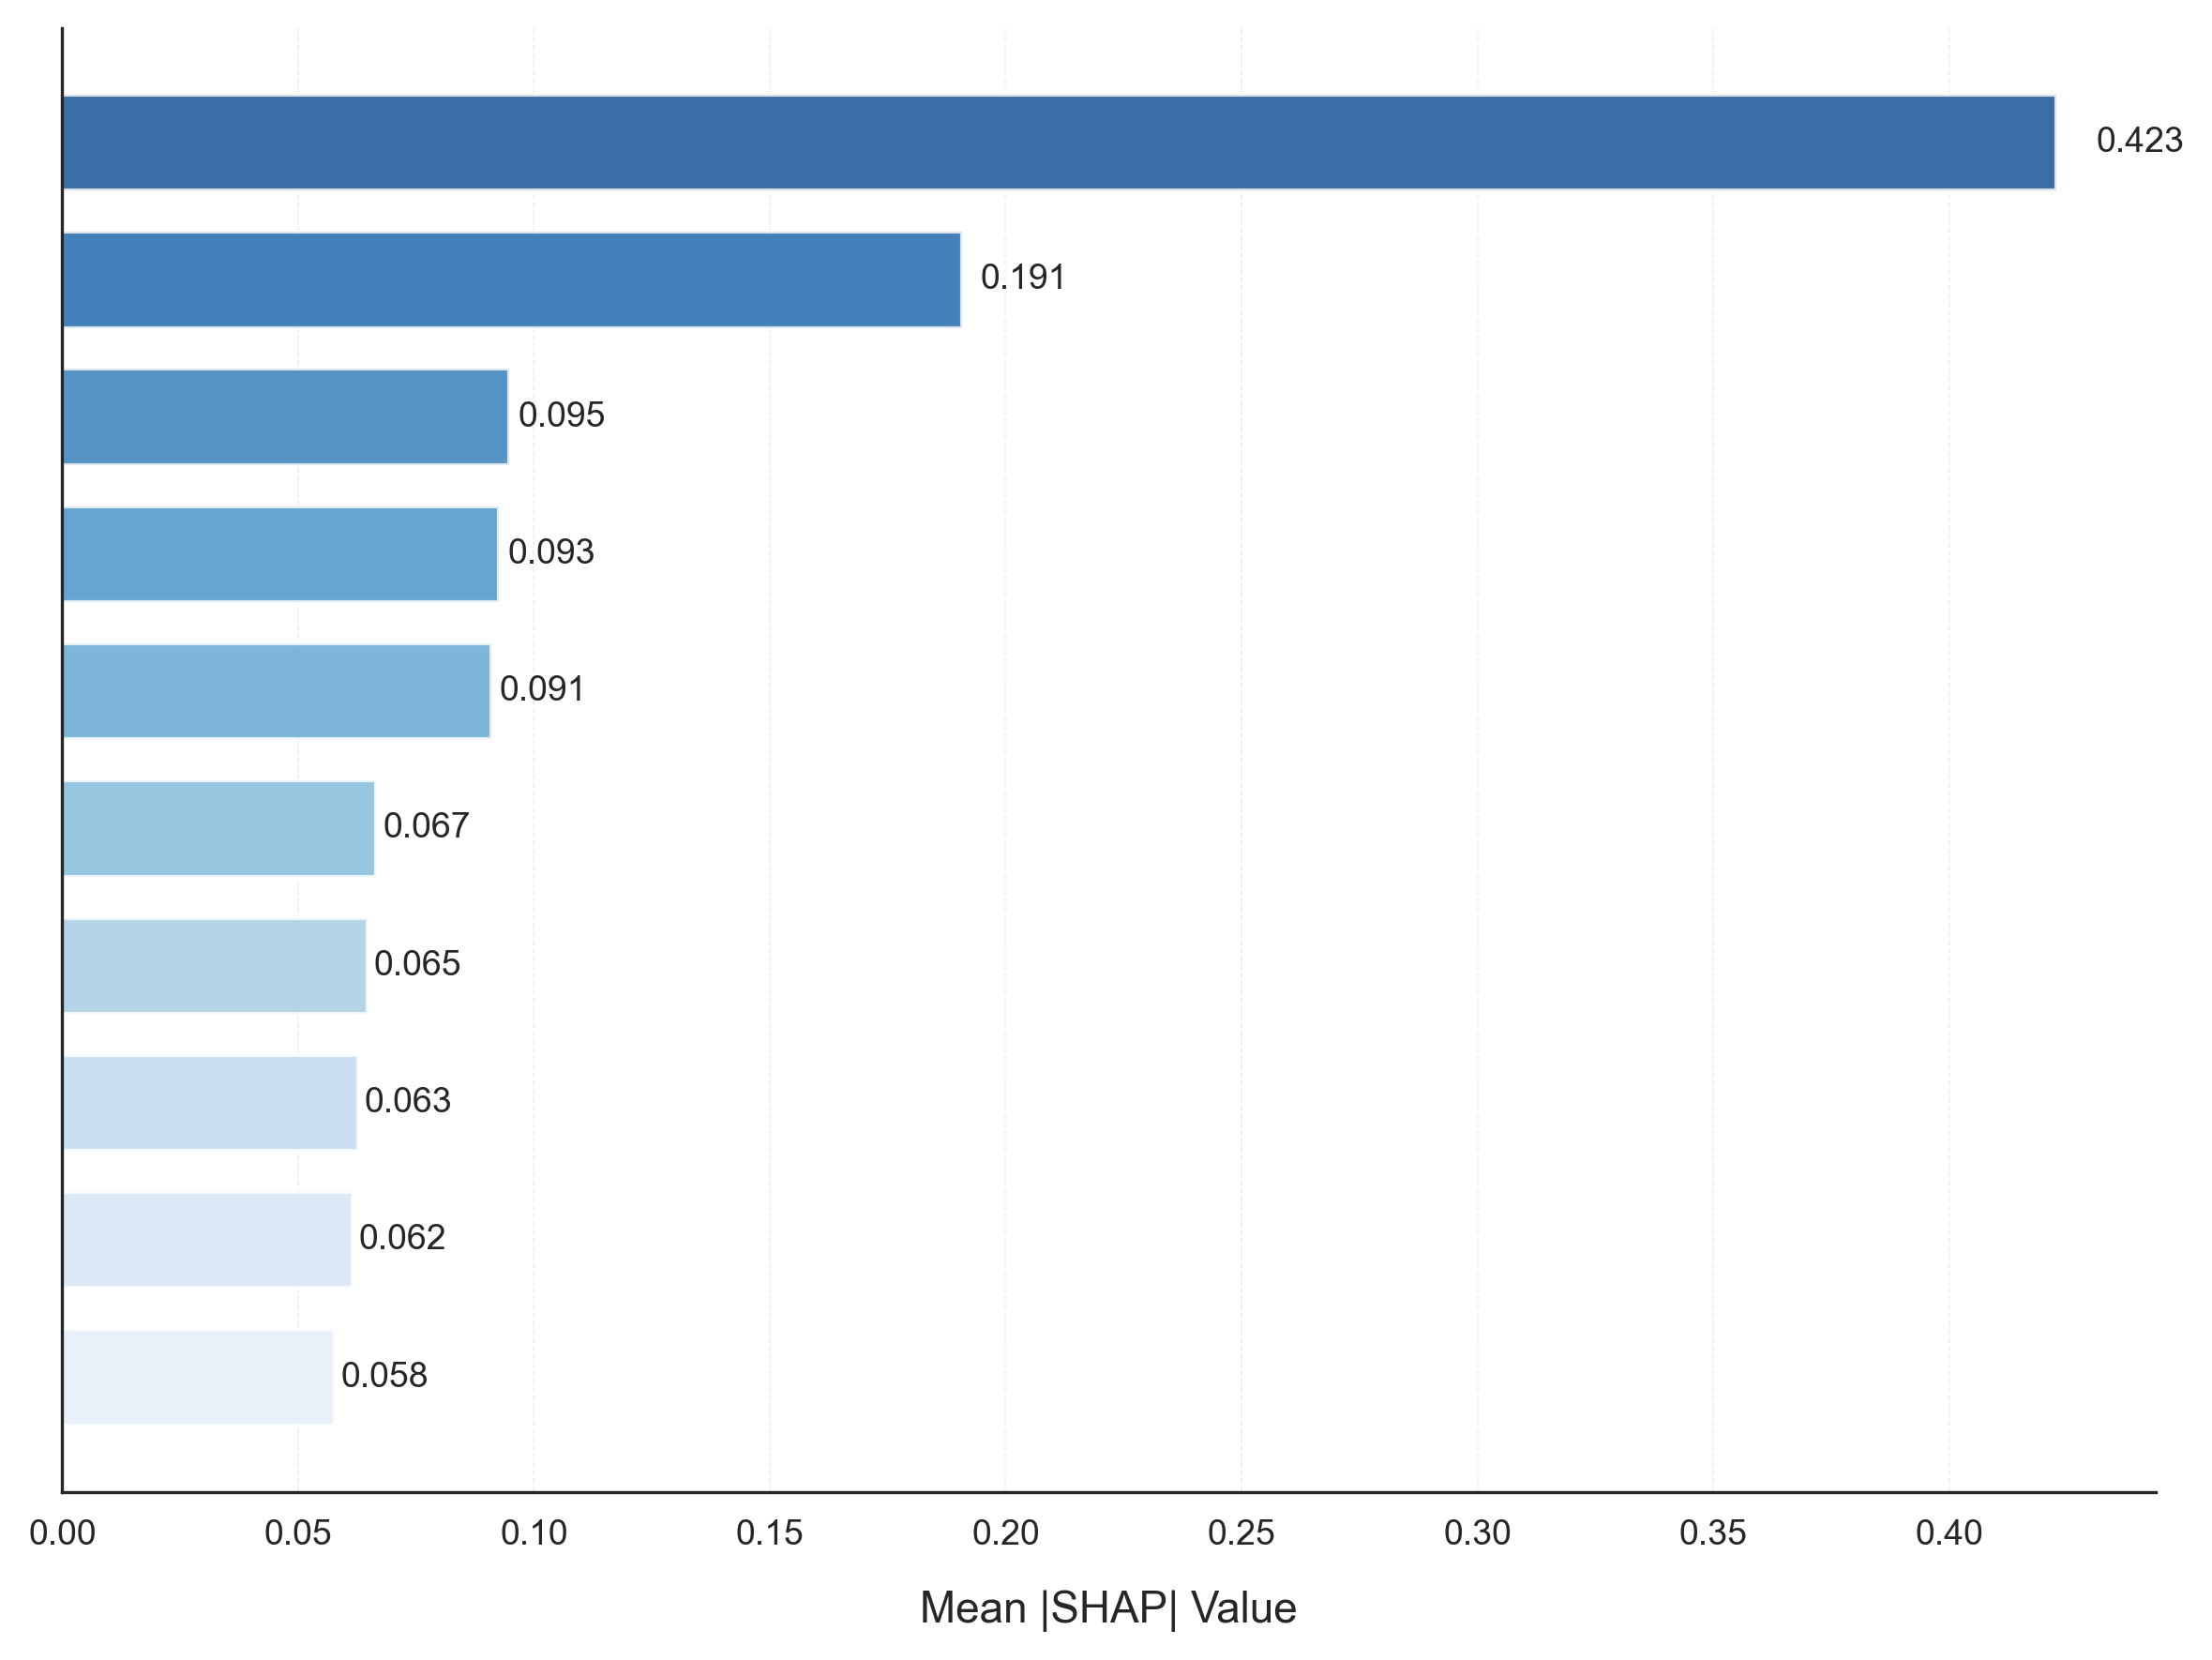

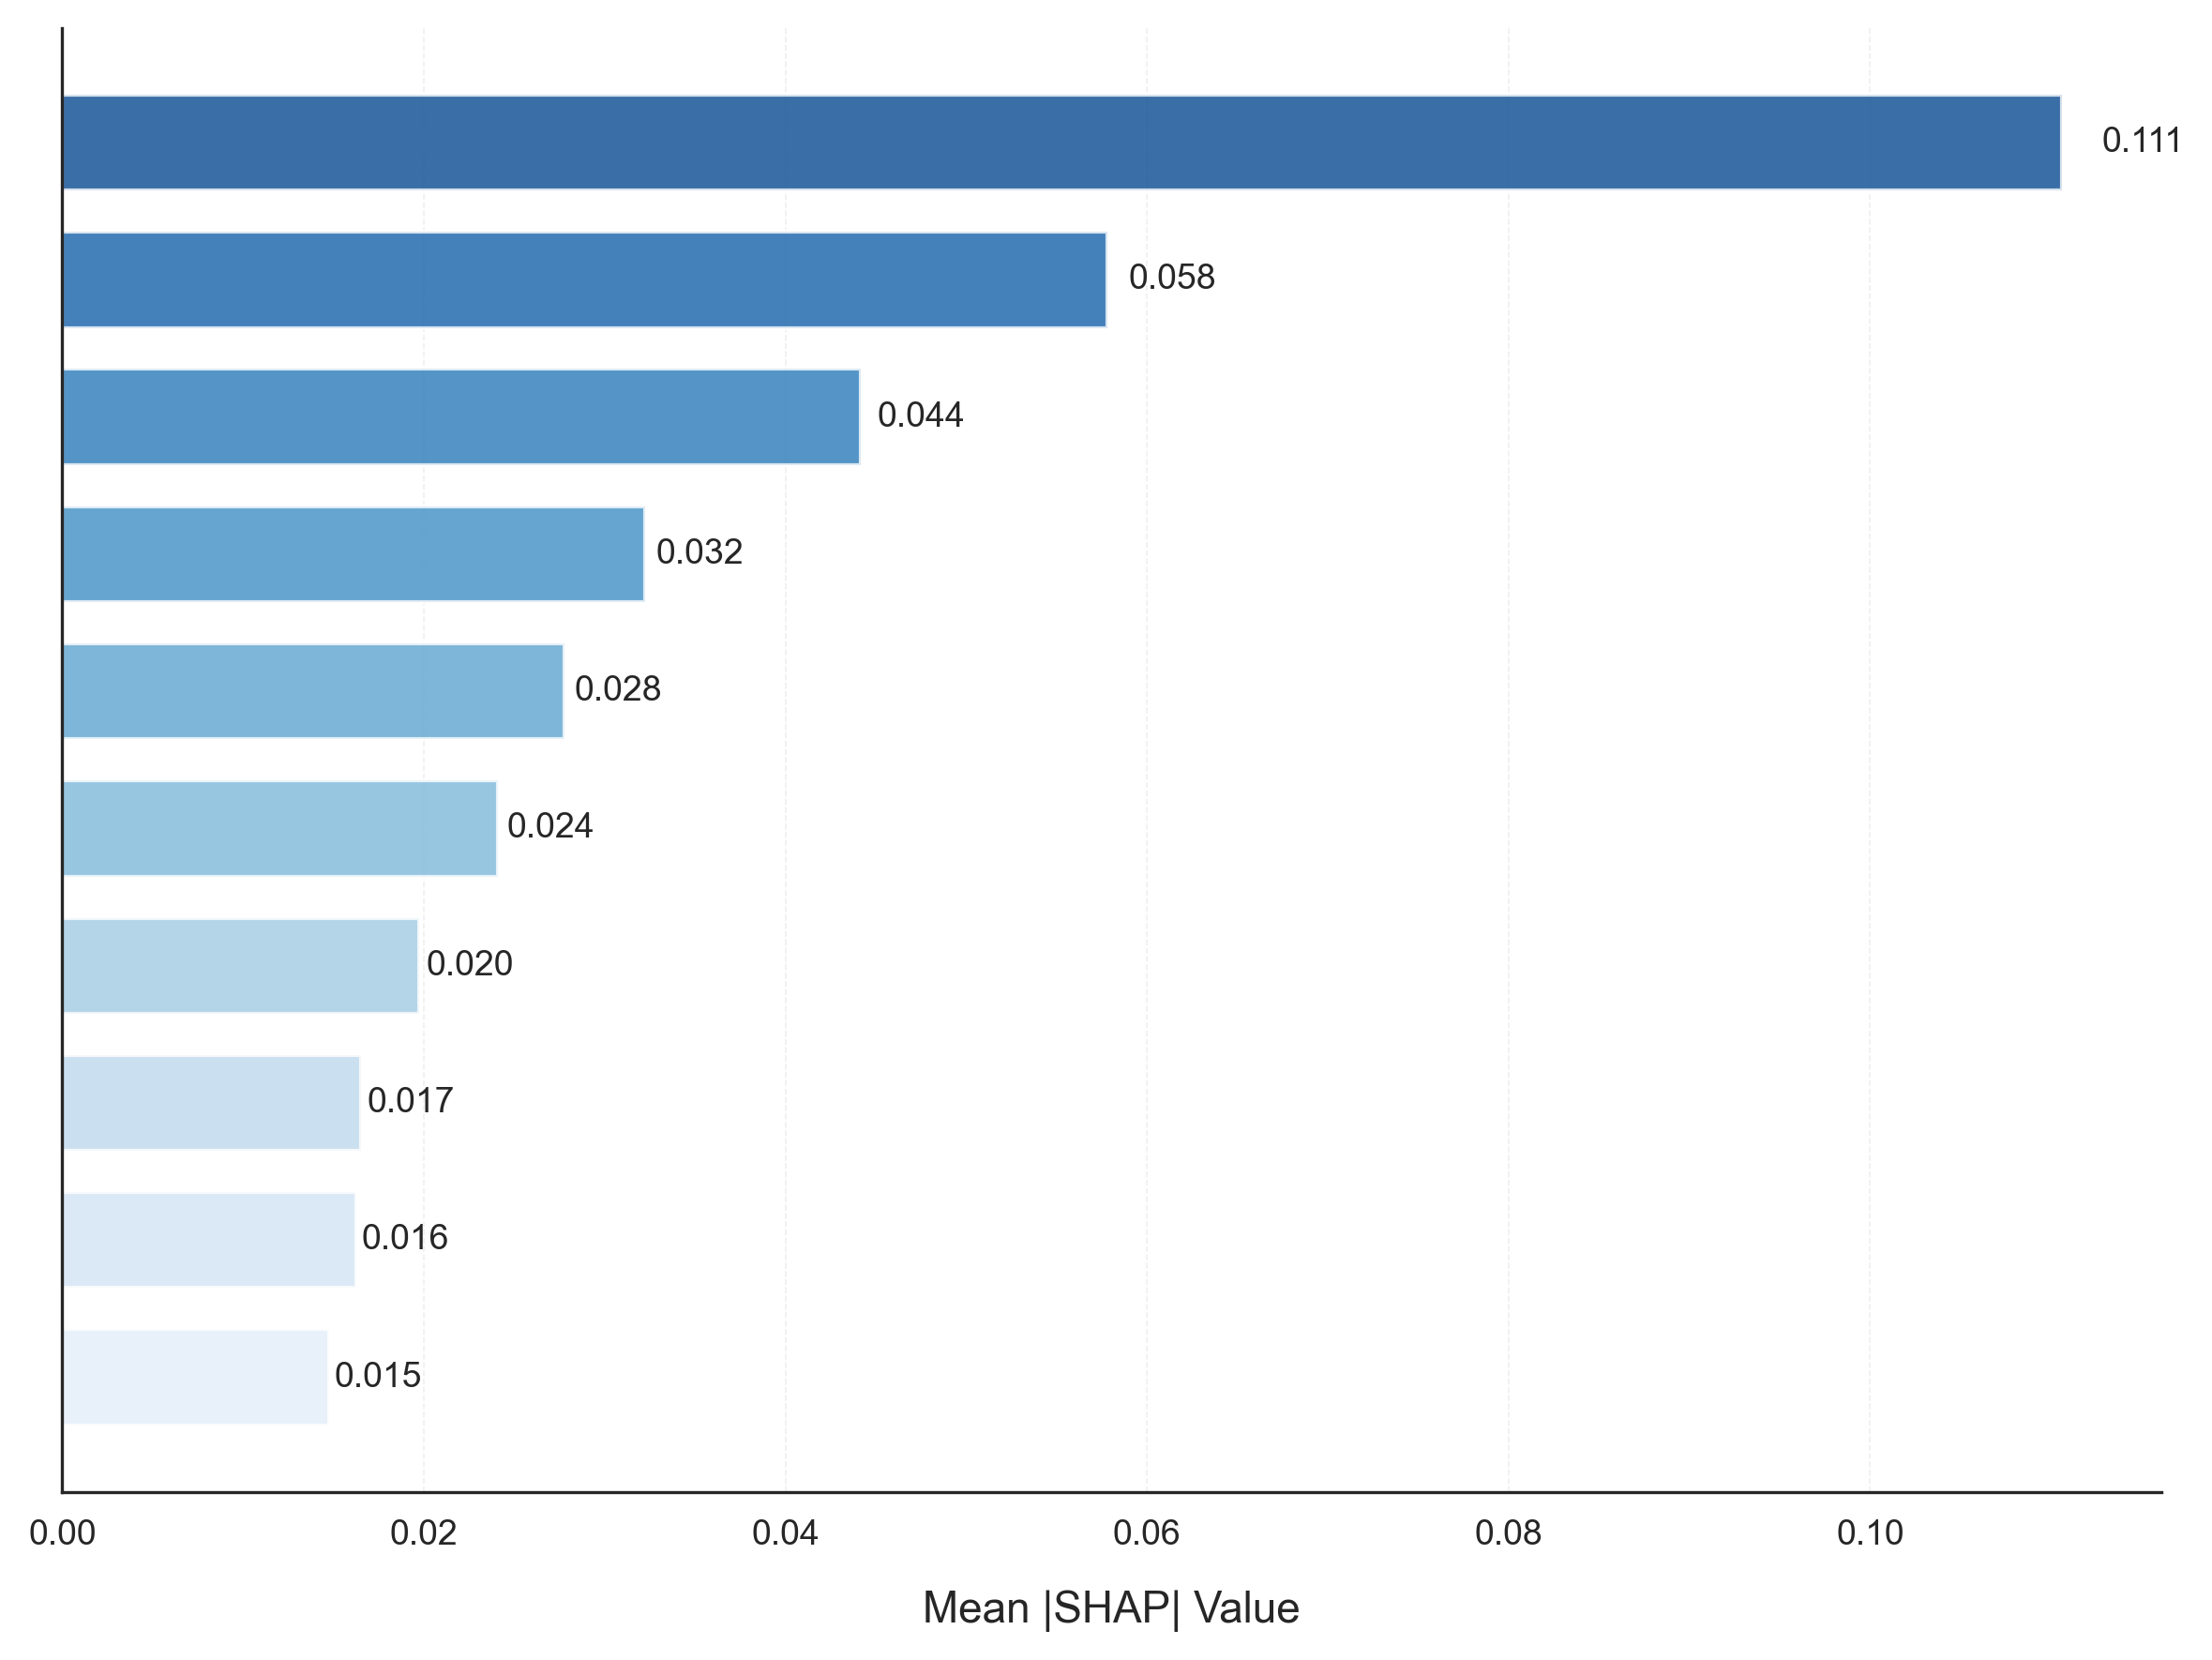

In [8]:
model_name = "LGBM"
best_params = pd.read_pickle("configs/model_config_baseline.pkl")

total_feature_importance_baseline = {}
total_feature_importance_baseline["death_y1"] = pd.DataFrame(
    index=all_input_data.columns
)
total_feature_importance_baseline["graft_loss_y1"] = pd.DataFrame(
    index=all_input_data.columns
)

all_predictions = pd.DataFrame()
for outcome in ["death_y1", "graft_loss_y1"]:
    # converted_params = convert_model_params(best_params[outcome], model_name)
    year_match = re.search(r"_y(\d+)", outcome)
    outcome_year = int(year_match.group(1))

    # Get and prepare input data
    input_data, cont_vars = get_input_data_for_outcome(
        outcome,
        baseline_data,
        baseline_data_cont,
        follow_up_predictors_total,
        follow_up_predictors_vars_by_year,
        follow_up_predictors_cont,
    )

    X = input_data.copy()
    X.rename(columns=lambda x: re.sub("[^A-Za-z0-9_]+", "", x), inplace=True)
    labels = outcome_data[[outcome]]
    outcome_type = "death" if "death" in outcome else "graft_loss"
    labels["outcome_type"] = outcome_type
    labels["outcome"] = outcome
    labels.rename(columns={outcome: "label"}, inplace=True)
    labels["year"] = int(outcome.split("_y")[1]) - 1

    X = X.loc[labels["label"].notnull()]
    labels = labels.loc[labels["label"].notnull()]

    # Cross-validation and SHAP calculation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    all_shap_values = []
    all_feature_values = []
    feature_names = X.columns
    sub_input_data_reorder = []
    for fold, (train_val_idx, test_idx) in enumerate(skf.split(X, labels["label"]), 1):
        X_train, X_test = X.iloc[train_val_idx], X.iloc[test_idx]
        y_train, y_test = labels.iloc[train_val_idx], labels.iloc[test_idx]
        sub_input_data_reorder.append(X_test.values)
        X_train, scaler = preprocess_data(X_train, baseline_data_cont.columns)
        X_test, _ = preprocess_data(X_test, baseline_data_cont.columns, scaler)

        model = lgbm.LGBMClassifier(**best_params[outcome], verbosity=-1)
        model.fit(X_train, y_train["label"])

        # Calculate SHAP values
        explainer = shap.TreeExplainer(model)
        fold_shap_values = explainer.shap_values(X_test)

        # For binary classification, take class 1 SHAP values
        if isinstance(fold_shap_values, list):
            fold_shap_values = fold_shap_values[1]

        # Store values
        all_shap_values.append(fold_shap_values)
        all_feature_values.append(X_test.values)

    # Combine values from all folds
    combined_shap_values = np.vstack(all_shap_values)
    combined_feature_values = np.vstack(all_feature_values)
    combined_feature_values_raw = np.vstack(sub_input_data_reorder)
    print(f"\nFor outcome {outcome}:")
    print(f"Combined SHAP values shape: {combined_shap_values.shape}")
    print(f"Combined feature values shape: {combined_feature_values.shape}")
    print(f"Number of features: {len(feature_names)}")

    # Create visualizations
    shap_df = pd.DataFrame(combined_shap_values, columns=feature_names)

    # 1. Mean absolute SHAP values visualization
    fig, top_features = visualize_shap(
        shap_df, path=f"plots/shap_importance_{outcome}.png"
    )
    feature_names = [
        NAME_MAPPING.get(col, col).replace("_", " ") for col in feature_names
    ]

    # 2. Beeswarm plot
    visualize_shap_beeswarm(
        combined_shap_values,
        combined_feature_values,
        feature_names=feature_names,
        path=f"plots/shap_beeswarm_{outcome}.png",
    )
    # 3. Feature-SHAP scatter plot for most important feature
    mean_abs_shap = np.abs(combined_shap_values).mean(axis=0)
    mean_abs_shap_series = pd.Series(mean_abs_shap, index=feature_names)
    mean_abs_shap_series = mean_abs_shap_series.reindex(
        total_feature_importance_baseline[outcome].index, fill_value=0
    )
    top_feature_idx = mean_abs_shap.argmax()
    top_feature_name = X.columns[top_feature_idx]

    create_feature_shap_scatter(
        combined_feature_values_raw[:, top_feature_idx],
        combined_shap_values[:, top_feature_idx],
        top_feature_name,
        path=f"plots/shap_scatter_{outcome}.png",
    )

    # Store feature importance
    total_feature_importance_baseline[outcome][
        f"fold_{fold}_importance"
    ] = mean_abs_shap_series

### follow-up year visualization


For outcome graft_loss_y1:
Combined SHAP values shape: (21292, 241)
Combined feature values shape: (21292, 241)
Number of features: 241
Index(['ec_transfusion_10', 'gluc', 'ldchol', 'coldisch_kidney1',
       'other_postTPX_diseaseCUM2', 'Proteinuria', 'dbp',
       'cardio_pulmonary_diseaseCUM2', 'eGFR', 'recipient_age'],
      dtype='object')
SHAP values shape: (21292, 241)
Features shape: (21292, 241)

For outcome graft_loss_y1:
Combined SHAP values shape: (20182, 241)
Combined feature values shape: (20182, 241)
Number of features: 241
Index(['gluc', 'first_rj', 'AMRCUM2', 'donage_complete', 'CKD4',
       'coldisch_kidney1', 'CKD3a', 'Proteinuria', 'crea', 'eGFR'],
      dtype='object')
SHAP values shape: (20182, 241)
Features shape: (20182, 241)


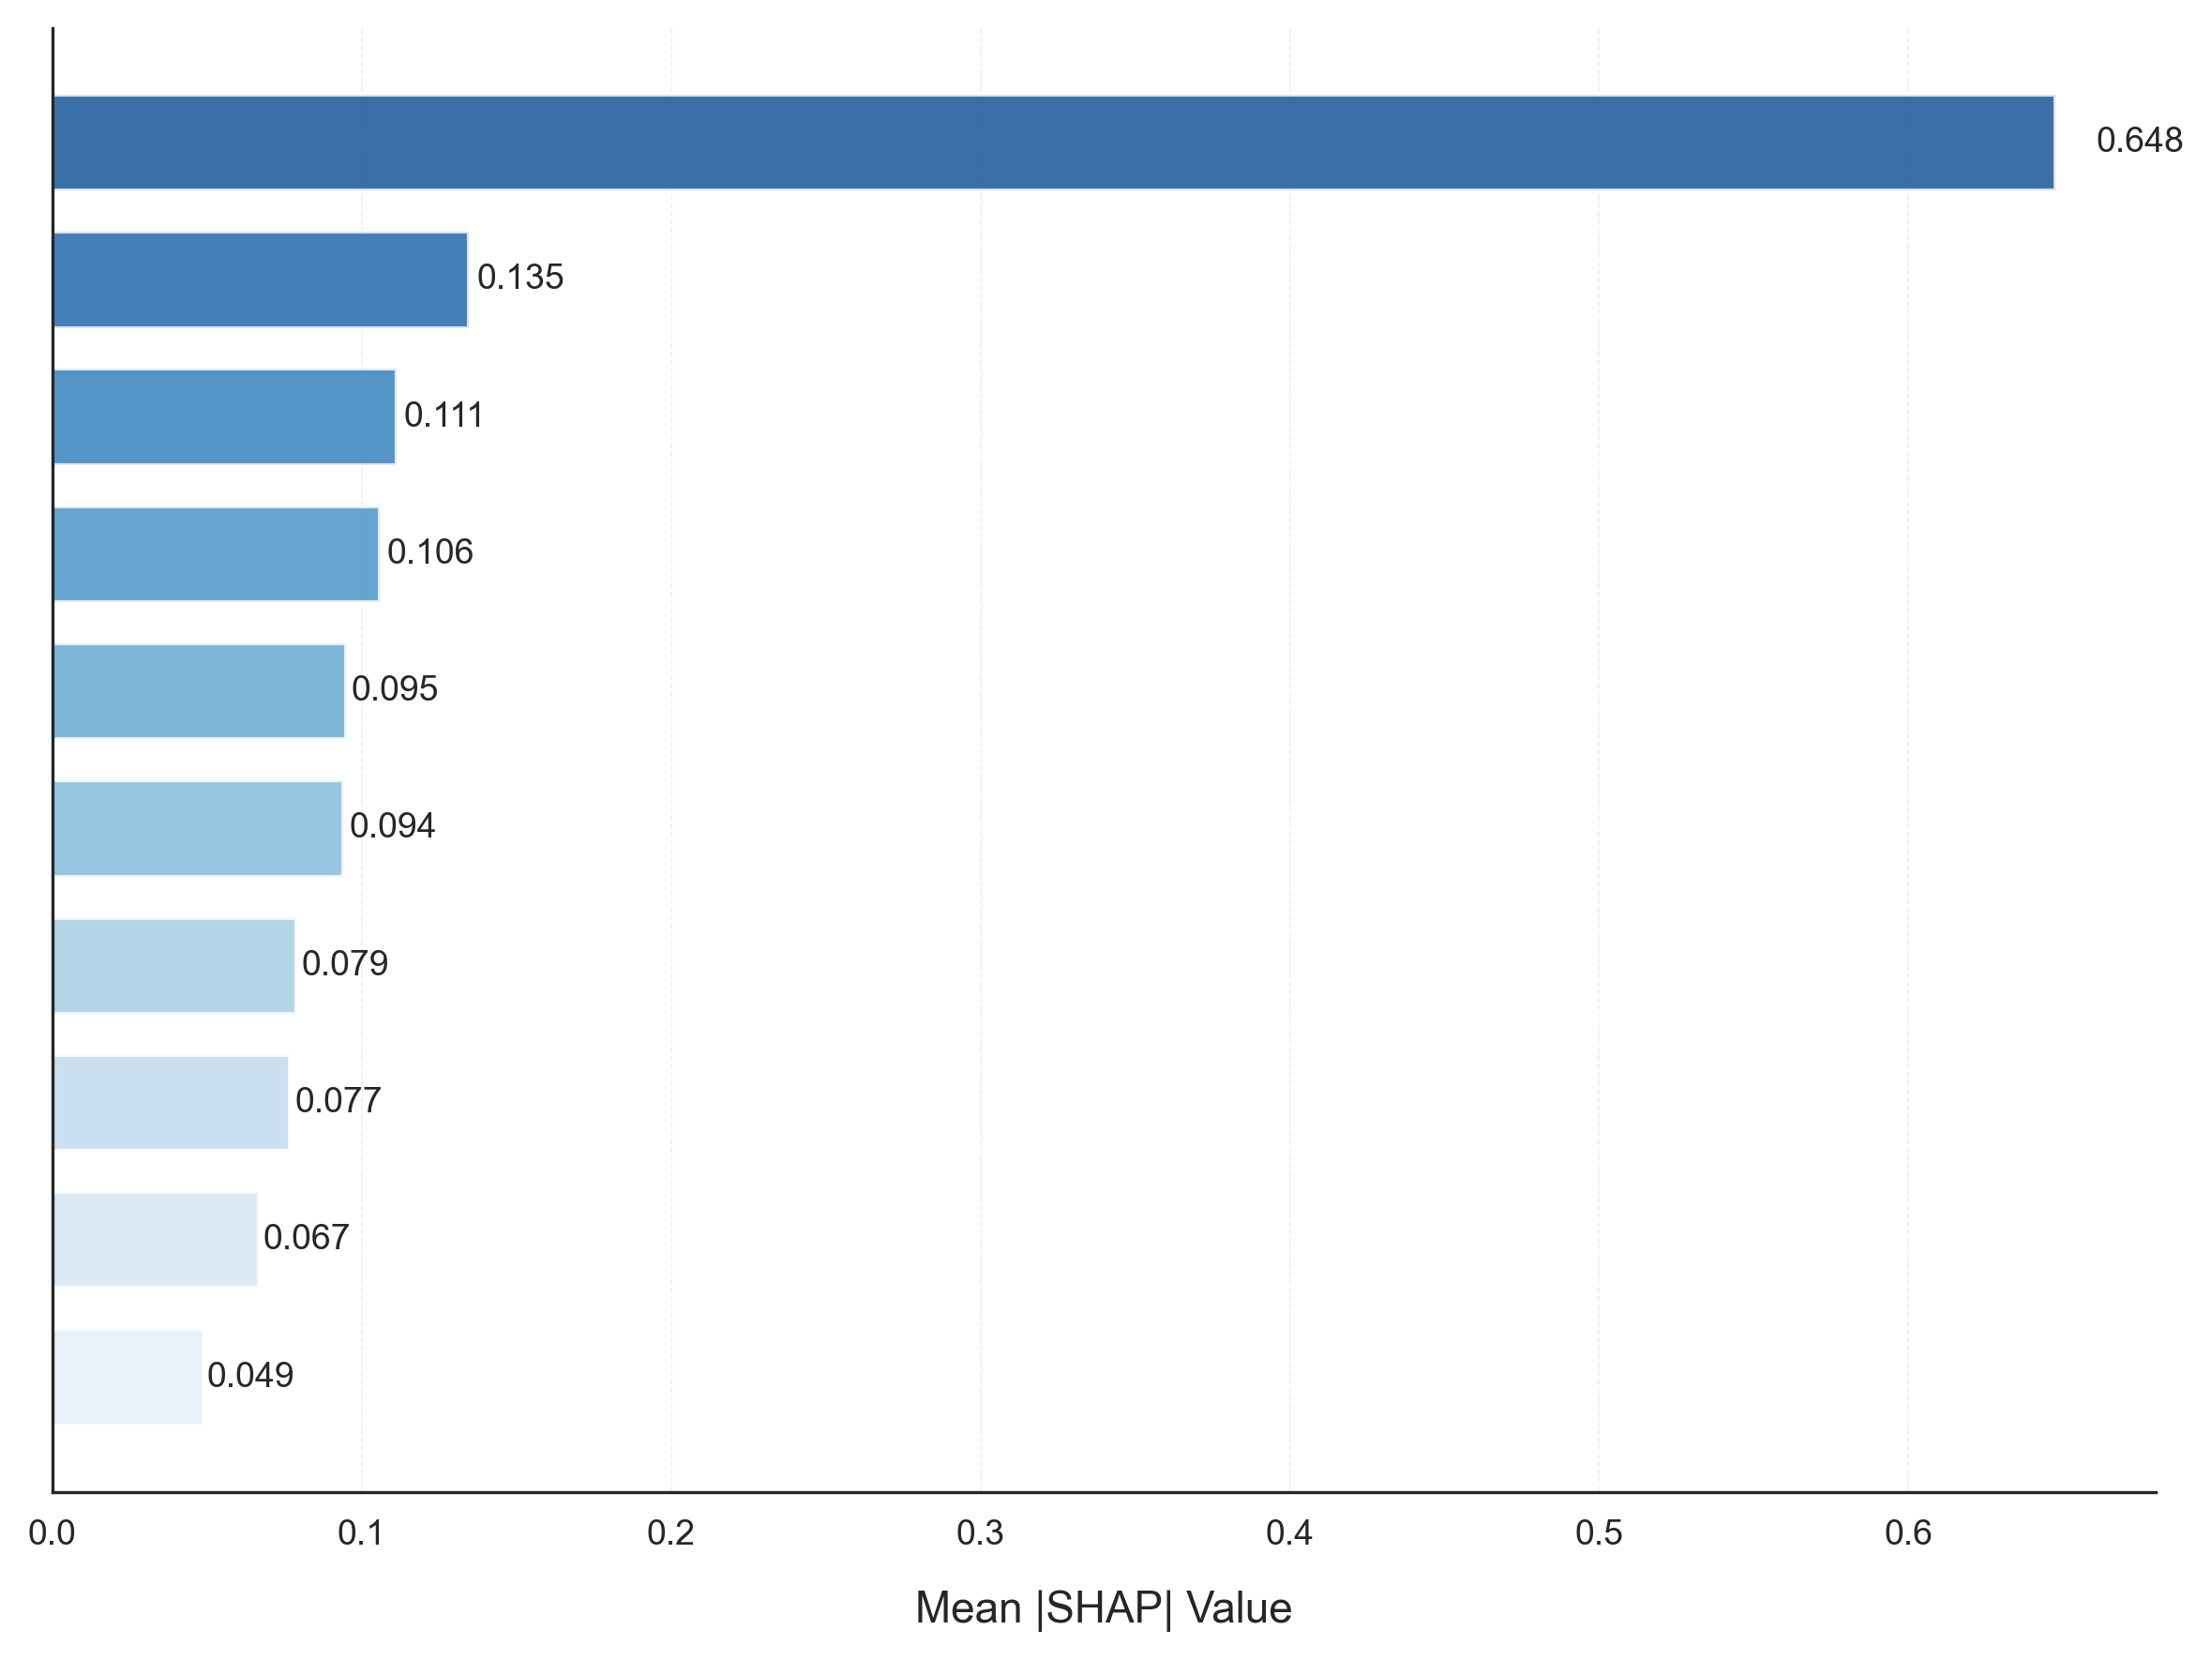

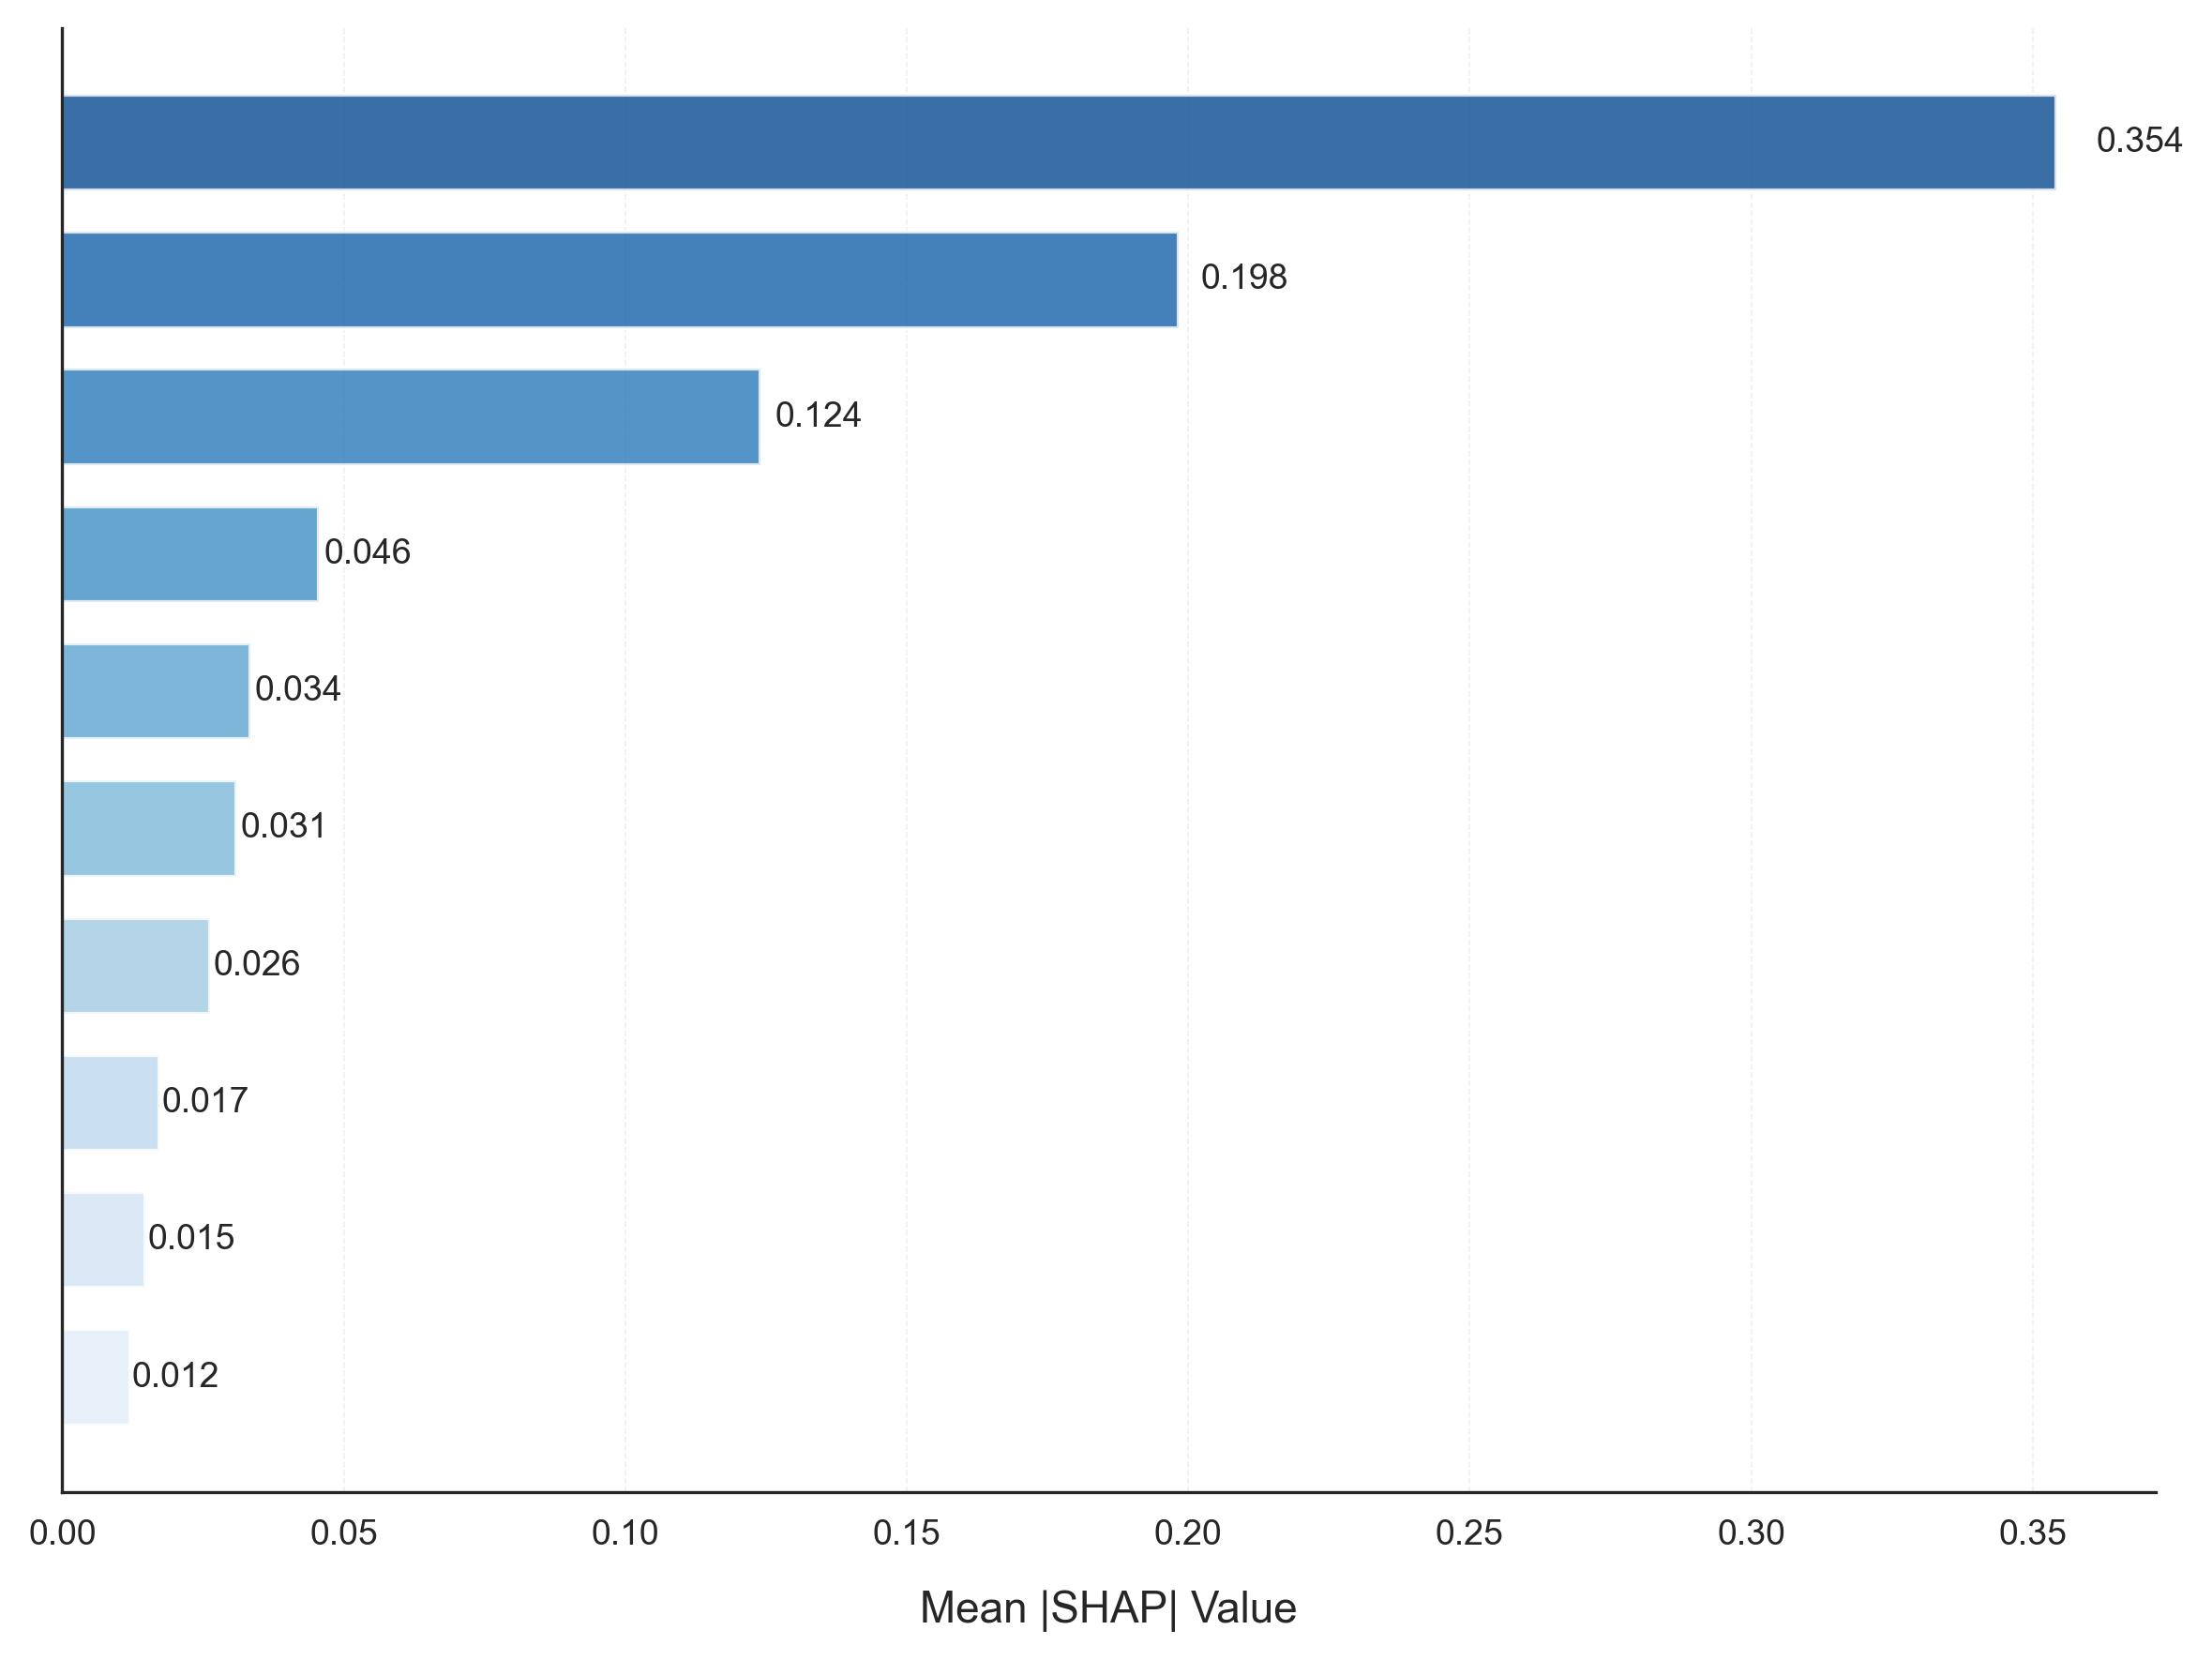

In [9]:
model_name = "LGBM"

best_params = pd.read_pickle("configs/model_config_followup.pkl")

cont_vars = [c for c in cont_vars if c in all_input_data.columns]
total_feature_importance_followup = {}
total_feature_importance_followup["death"] = pd.DataFrame(index=all_input_data.columns)
total_feature_importance_followup["graft_loss"] = pd.DataFrame(
    index=all_input_data.columns
)

for outcome_type in ["death", "graft_loss"]:
    sub_input_data = all_input_data.loc[all_outcomes["type"] == outcome_type]
    sub_outcomes = all_outcomes.loc[all_outcomes["type"] == outcome_type]
    sub_input_data = sub_input_data.loc[sub_outcomes["label"].notnull()]
    sub_input_data.drop(columns=['year'], inplace=True)
    sub_outcomes = sub_outcomes.loc[sub_outcomes["label"].notnull()][
        ["label", "outcome", "year"]
    ]
    outcome_years = [
        int(re.search(r"_y(\d+)", o).group(1)) for o in sub_outcomes["outcome"]
    ]
    sub_input_data.rename(
        columns=lambda x: re.sub("[^A-Za-z0-9_]+", "", x), inplace=True
    )
    # sub_input_data.drop(columns=['year'], inplace=True)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    all_shap_values = []
    all_feature_values = []
    feature_names = sub_input_data.columns
    sub_input_data_reorder = []
    for fold_idx, (train_idx, test_idx) in enumerate(
        skf.split(sub_input_data, sub_outcomes["label"]), 1
    ):
        X_train, y_train = sub_input_data.iloc[train_idx], sub_outcomes.iloc[train_idx]
        X_test, y_test = sub_input_data.iloc[test_idx], sub_outcomes.iloc[test_idx]
        sub_input_data_reorder.append(X_test.values)
        X_train, scaler = preprocess_data(X_train, cont_vars)
        X_test, _ = preprocess_data(X_test, cont_vars, scaler)
        
        model = lgbm.LGBMClassifier(**best_params[outcome_type], verbosity=-1)
        model.fit(X_train, y_train["label"])

        # Calculate SHAP values
        explainer = shap.TreeExplainer(model)
        fold_shap_values = explainer.shap_values(X_test)

        # For binary classification, take class 1 SHAP values
        if isinstance(fold_shap_values, list):
            fold_shap_values = fold_shap_values[1]

        # Store values
        all_shap_values.append(fold_shap_values)
        all_feature_values.append(X_test.values)
        
        

    # Combine values from all folds
    combined_shap_values = np.vstack(all_shap_values)
    combined_feature_values = np.vstack(all_feature_values)
    combined_feature_values_raw = np.vstack(sub_input_data_reorder)
    print(f"\nFor outcome {outcome}:")
    print(f"Combined SHAP values shape: {combined_shap_values.shape}")
    print(f"Combined feature values shape: {combined_feature_values.shape}")
    print(f"Number of features: {len(feature_names)}")

    # Create visualizations
    shap_df = pd.DataFrame(combined_shap_values, columns=feature_names)

    # 1. Mean absolute SHAP values visualization
    visualize_shap(
        shap_df,
        title_prefix=f"Outcome: {outcome_type}",
        path=f"plots/shap_importance_{outcome_type}.png",
    )

    feature_names = [
        NAME_MAPPING.get(col, col).replace("_", " ") for col in feature_names
    ]

    # 2. Beeswarm plot
    visualize_shap_beeswarm(
        combined_shap_values,
        combined_feature_values,
        feature_names=feature_names,
        path=f"plots/shap_beeswarm_{outcome_type}.png",
    )
    # 3. Feature-SHAP scatter plot for most important feature
    mean_abs_shap = np.abs(combined_shap_values).mean(axis=0)
    mean_abs_shap_series = pd.Series(mean_abs_shap, index=feature_names)
    mean_abs_shap_series = mean_abs_shap_series.reindex(
        total_feature_importance_followup[outcome_type].index, fill_value=0
    )
    top_feature_idx = mean_abs_shap.argmax()
    top_feature_name = sub_input_data.columns[top_feature_idx]
    
    create_feature_shap_scatter(
        combined_feature_values_raw[:, top_feature_idx],
        combined_shap_values[:, top_feature_idx],
        top_feature_name,
        title=f"Feature-SHAP Relationship - {outcome_type}\nTop Feature: {top_feature_name}",
        path=f"plots/shap_scatter_{outcome_type}.png",
    )
    

In [39]:
model_name = "LGBM"

following_year = pd.read_csv(
    f"{dataset}/results/next_year_prediction_results_{model_name}_multi_year_training.csv"
)
best_params = get_best_model_params(following_year, param_names)

cont_vars = [c for c in cont_vars if c in all_input_data.columns]
total_feature_importance_followup = {}
total_feature_importance_followup["death"] = pd.DataFrame(index=all_input_data.columns)
total_feature_importance_followup["graft_loss"] = pd.DataFrame(
    index=all_input_data.columns
)
all_shap_df = pd.DataFrame()
for outcome_type in ["death", "graft_loss"]:
    sub_input_data = all_input_data.loc[all_outcomes["type"] == outcome_type]
    sub_outcomes = all_outcomes.loc[all_outcomes["type"] == outcome_type]
    sub_input_data = sub_input_data.loc[sub_outcomes["label"].notnull()]
    sub_input_data.drop(columns=['year'], inplace=True)
    sub_outcomes = sub_outcomes.loc[sub_outcomes["label"].notnull()][
        ["label", "outcome", "year"]
    ]
    outcome_years = [
        int(re.search(r"_y(\d+)", o).group(1)) for o in sub_outcomes["outcome"]
    ]
    sub_input_data.rename(
        columns=lambda x: re.sub("[^A-Za-z0-9_]+", "", x), inplace=True
    )

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    all_shap_values = []
    all_feature_values = []
    all_years = []  # <-- We'll store the 'year' for each row here
    feature_names = sub_input_data.columns
    sub_input_data_reorder = []

    for fold_idx, (train_idx, test_idx) in enumerate(
        skf.split(sub_input_data, sub_outcomes["label"]), 1
    ):
        X_train, y_train = sub_input_data.iloc[train_idx], sub_outcomes.iloc[train_idx]
        X_test, y_test = sub_input_data.iloc[test_idx], sub_outcomes.iloc[test_idx]
        sub_input_data_reorder.append(X_test.values)

        X_train, scaler = preprocess_data(X_train, cont_vars)
        X_test, _ = preprocess_data(X_test, cont_vars, scaler)

        model = lgbm.LGBMClassifier(**best_params[outcome_type], verbosity=-1)
        model.fit(X_train, y_train["label"])

        # Calculate SHAP values
        explainer = shap.TreeExplainer(model)
        fold_shap_values = explainer.shap_values(X_test)

        # For binary classification, take class 1 SHAP values
        if isinstance(fold_shap_values, list):
            fold_shap_values = fold_shap_values[1]

        # Store fold results
        all_shap_values.append(fold_shap_values)
        all_feature_values.append(X_test.values)
        all_years.append(y_test["year"].values)  # <-- Collect 'year' information

    # Combine values from all folds
    combined_shap_values = np.vstack(all_shap_values)
    combined_feature_values = np.vstack(all_feature_values)
    combined_feature_values_raw = np.vstack(sub_input_data_reorder)

    # Combine all years
    combined_years = np.concatenate(all_years)

    print(f"\nFor outcome {outcome_type}:")
    print(f"Combined SHAP values shape: {combined_shap_values.shape}")
    print(f"Combined feature values shape: {combined_feature_values.shape}")
    print(f"Number of features: {len(feature_names)}")

    # Create a DataFrame of SHAP values
    shap_df = pd.DataFrame(combined_shap_values, columns=feature_names)

    # ---------------------- NEW BLOCK FOR SAVING SHAP VALUES ----------------------
    # Add the 'year' and 'outcome_type' columns so we can track the temporal aspect
    shap_df['year'] = combined_years
    shap_df['outcome_type'] = outcome_type
    
    all_shap_df = pd.concat([all_shap_df, shap_df])

    # Save this to a CSV for later visualization
    # ------------------------------------------------------------------------------

#     # 1. Mean absolute SHAP values visualization
#     visualize_shap(
#         shap_df,
#         title_prefix=f"Outcome: {outcome_type}",
#         path=f"plots/shap_importance_{outcome_type}.png",
#     )

#     # For beeswarm and scatter plots, let's create a friendlier feature name mapping
#     mapped_feature_names = [
#         NAME_MAPPING.get(col, col).replace("_", " ") for col in feature_names
#     ]

#     # 2. Beeswarm plot
#     visualize_shap_beeswarm(
#         combined_shap_values,
#         combined_feature_values,
#         feature_names=mapped_feature_names,
#         path=f"plots/shap_beeswarm_{outcome_type}.png",
#     )

#     # 3. Feature-SHAP scatter plot for most important feature
#     mean_abs_shap = np.abs(combined_shap_values).mean(axis=0)
#     mean_abs_shap_series = pd.Series(mean_abs_shap, index=feature_names)
#     mean_abs_shap_series = mean_abs_shap_series.reindex(
#         total_feature_importance_followup[outcome_type].index, fill_value=0
#     )
#     top_feature_idx = mean_abs_shap.argmax()
#     top_feature_name = sub_input_data.columns[top_feature_idx]

#     create_feature_shap_scatter(
#         combined_feature_values_raw[:, top_feature_idx],
#         combined_shap_values[:, top_feature_idx],
#         top_feature_name,
#         title=(
#             f"Feature-SHAP Relationship - {outcome_type}\n"
#             f"Top Feature: {top_feature_name}"
#         ),
#         path=f"plots/shap_scatter_{outcome_type}.png",
#     )




For outcome death:
Combined SHAP values shape: (21292, 241)
Combined feature values shape: (21292, 241)
Number of features: 241

For outcome graft_loss:
Combined SHAP values shape: (20182, 241)
Combined feature values shape: (20182, 241)
Number of features: 241


In [41]:
all_shap_df

,recipient_age,donage_complete,bmi_rec0,sbp_rec0,dbp_rec0,eGFR_rec0,ldchol_rec0,hdchol_rec0,gluc_rec0,coldisch_kidney1,...,cardio_pulmonary_diseaseCUM2,metabolic_diseaseCUM2,hypertensionCUM2,CKD2,CKD3a,CKD3b,CKD4,CKD5,year,outcome_type
0,-0.787238,-0.012337,0.010261,-0.010689,0.002258,-0.015897,-0.014683,-0.006144,-0.003229,0.013101,...,-0.051120,-0.023200,-0.001175,-0.000011,-0.009151,-0.000004,-0.002302,-0.000156,1,death
1,-1.085686,-0.012238,0.006743,-0.014916,0.005257,-0.033386,0.026659,0.002618,-0.001337,-0.052217,...,-0.065175,-0.043067,-0.000915,-0.000011,-0.005592,0.000085,-0.001778,-0.000139,1,death
2,0.164106,0.127414,-0.009934,-0.023018,-0.045511,-0.013341,-0.007060,0.004148,0.000921,0.133679,...,-0.051700,-0.031143,-0.002750,-0.000004,0.004472,-0.000005,-0.003527,-0.000024,1,death
3,-1.234793,-0.014119,-0.011408,-0.009136,-0.008995,-0.026091,-0.019138,-0.004621,-0.006909,0.020135,...,-0.052470,-0.080670,-0.001191,-0.000011,0.004951,0.000016,-0.002317,-0.000131,1,death
4,0.934831,-0.014540,0.022899,-0.031047,0.021002,-0.008931,-0.006715,0.029197,-0.003857,0.009821,...,-0.084830,-0.043832,-0.002656,-0.000002,0.004745,0.000167,-0.004488,-0.000024,1,death
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20177,0.026868,-0.140638,-0.012618,0.005375,0.009069,-0.003015,0.000216,0.001642,-0.003581,-0.063168,...,-0.007905,-0.002343,0.000000,0.000000,0.039822,-0.007919,-0.024429,-0.000913,12,graft_loss
20178,-0.001849,0.012665,-0.001229,-0.000036,0.010107,0.027709,-0.003013,0.000068,-0.008560,-0.030932,...,-0.002757,-0.001197,0.000000,0.000000,0.038717,0.015434,-0.017676,-0.000490,12,graft_loss
20179,-0.001287,-0.036786,0.000431,0.000687,-0.000658,-0.000500,-0.009923,-0.000050,-0.008420,-0.016471,...,-0.002460,-0.001120,0.000000,0.000000,-0.062045,-0.005028,-0.013253,-0.000357,12,graft_loss
20180,-0.001528,0.099351,0.000115,0.003790,-0.002664,-0.003482,-0.007450,0.000388,-0.007739,-0.018512,...,-0.008567,-0.001713,0.000000,0.000000,0.027438,0.014726,-0.014285,-0.000506,12,graft_loss


In [43]:
def evaluate_temporal_dynamics_of_top_features(
    shap_df, 
    outcome_type, 
    top_n=10, 
    max_year=12,
    save_path=None
):
    """
    Evaluate the temporal dynamics (from year 1 to year 12) of the top N 
    overall important features. Plots the mean absolute SHAP values for 
    each feature by year, with legend in descending order of importance 
    (and mapped feature names).

    Parameters
    ----------
    shap_df : pd.DataFrame
        A DataFrame containing the SHAP values for each feature (wide format), 
        plus 'year' and 'outcome_type' columns. 
        Example columns:
            ['feature1', 'feature2', ..., 'year', 'outcome_type']
    outcome_type : str
        The outcome label (e.g., 'death', 'graft_loss') used for labeling the plot.
    top_n : int, default=10
        Number of top features to visualize based on mean absolute SHAP value 
        (across all years).
    max_year : int, default=12
        Only consider data up to this year (e.g., 12).
    save_path : str, optional
        File path to save the resulting plot. If None, the plot is only shown.
    """

    import seaborn as sns
    import matplotlib.pyplot as plt

    # 1. Filter the DataFrame by outcome_type and years up to max_year
    shap_df_filtered = shap_df[
        (shap_df["outcome_type"] == outcome_type) 
        & (shap_df["year"] <= max_year)
    ].copy()

    # 2. Convert from wide to long format (one row per feature value)
    melted = shap_df_filtered.melt(
        id_vars=["year", "outcome_type"], 
        var_name="feature", 
        value_name="shap_value"
    )

    # 3. Determine top N features by mean absolute SHAP (descending)
    feature_mean_abs = (
        melted.assign(abs_shap=lambda df: df["shap_value"].abs())
        .groupby("feature")["abs_shap"]
        .mean()
        .sort_values(ascending=False)
    )
    top_features = feature_mean_abs.head(top_n).index.tolist()

    # 4. Filter to only include top N features
    melted_top = melted[melted["feature"].isin(top_features)].copy()

    # 5. Compute mean absolute SHAP by (year, feature)
    melted_top["abs_shap"] = melted_top["shap_value"].abs()
    df_plot = (
        melted_top.groupby(["year", "feature"], as_index=False)["abs_shap"]
        .mean()
        .rename(columns={"abs_shap": "mean_abs_shap"})
    )

    # ---- NEW: Apply NAME_MAPPING and fix legend order ----
    # Create a new column with mapped feature names
    df_plot["feature_mapped"] = df_plot["feature"].map(NAME_MAPPING).fillna(df_plot["feature"])

    # We need the top features in *descending* order by importance 
    # but replaced with mapped names:
    # (The actual order is from feature_mean_abs, so we just map those directly.)
    top_features_mapped_ordered = [
        NAME_MAPPING.get(feat, feat) for feat in top_features
    ]

    # 6. Create the line plot with Seaborn
    plt.figure(figsize=(12, 7))
    ax = sns.lineplot(
        data=df_plot, 
        x="year", 
        y="mean_abs_shap", 
        hue="feature_mapped",
        hue_order=top_features_mapped_ordered,  # enforce legend order
        marker="o", 
        linewidth=2, 
        markersize=8,
    )

    ax.set_title(
        f"Temporal Dynamics of Top {top_n} Features (Mean |SHAP|)\n"
        f"Outcome: {outcome_type.replace('_', ' ').title()}",
        fontsize=14,
        pad=20,
    )
    ax.set_xlabel("Year", fontsize=12)
    ax.set_ylabel("Mean Absolute SHAP", fontsize=12)

    # The legend now shows in the order we specified via `hue_order`
    ax.legend(title="Feature", bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    # 7. Optionally save the plot
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()

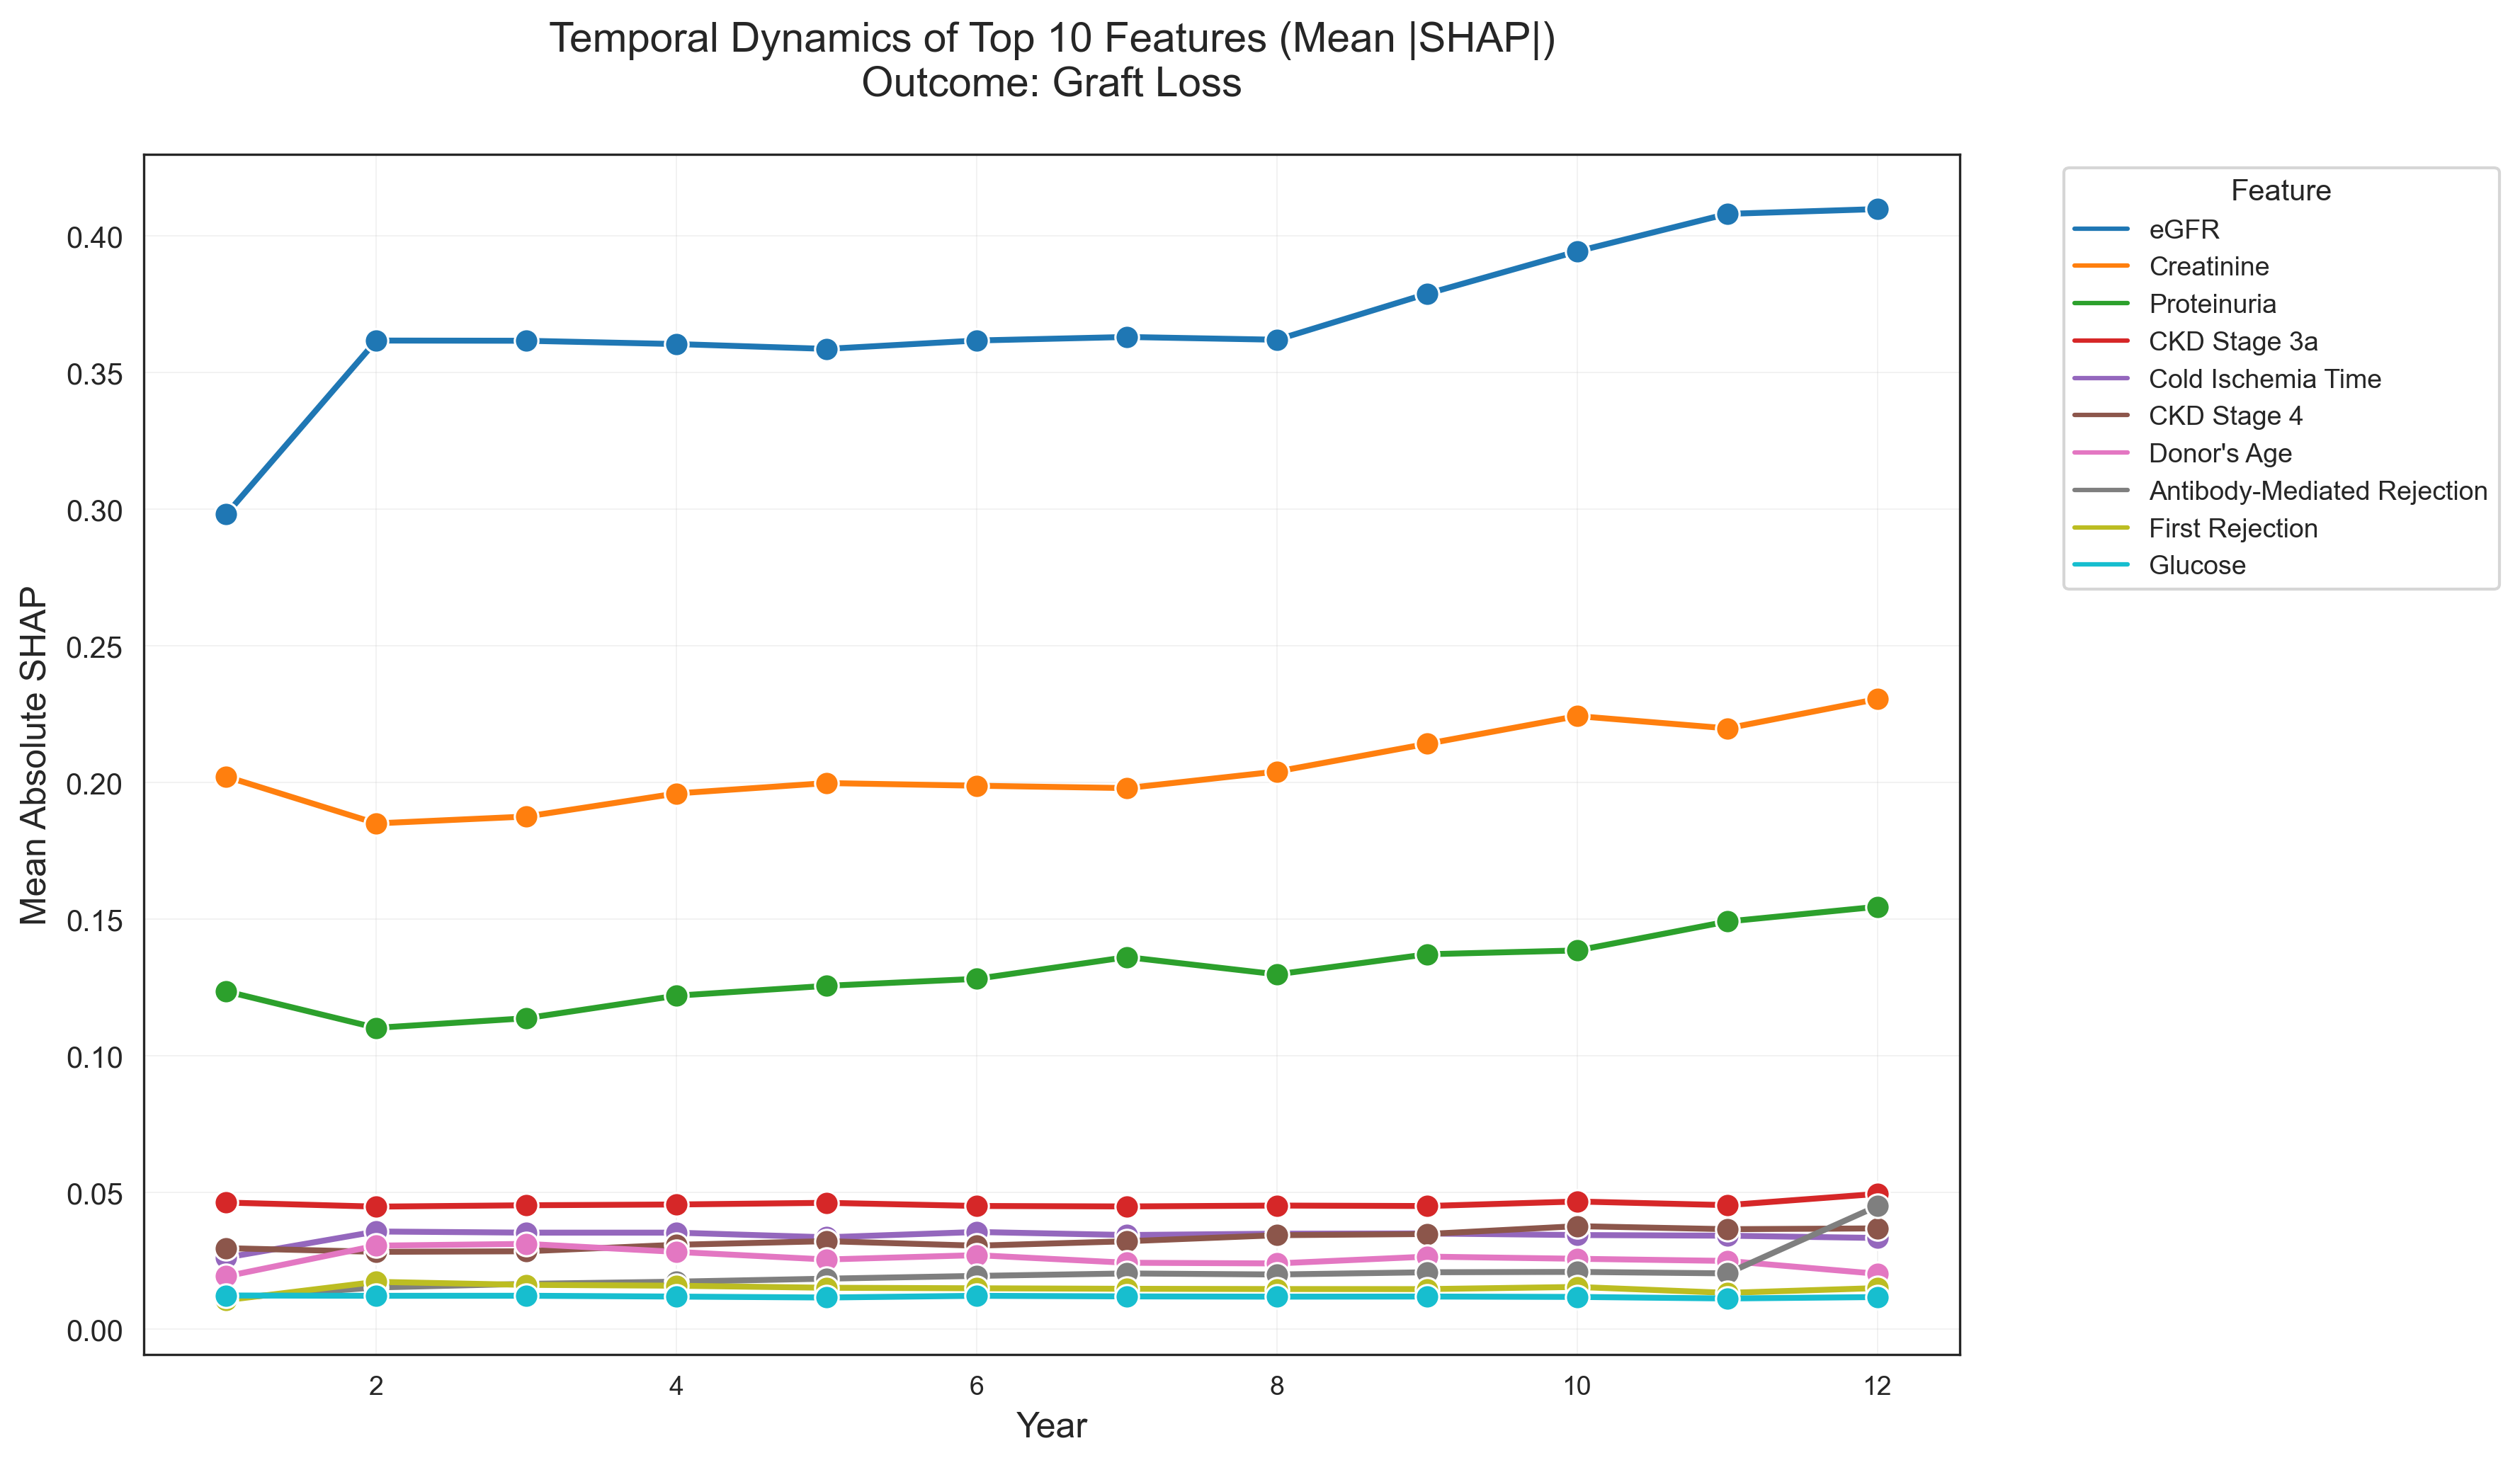

In [46]:
evaluate_temporal_dynamics_of_top_features(
    all_shap_df,
    "graft_loss",
    top_n=10,
    save_path="Manuscript Figures/Supp_temporal_shap_evolution_graft_loss.png",
)

##  feature importance visualization

In [ ]:
def create_feature_importance_df(outcome_results, outcome_type):
    """
    Convert the nested dictionary structure to a DataFrame suitable for plotting
    """
    data = []
    # First convert defaultdict to regular dict
    outcome_dict = dict(outcome_results[outcome_type])

    for feature, feature_data in outcome_dict.items():
        values = feature_data["values"]
        for year, value in enumerate(values, 1):
            data.append({"Feature": feature, "Year": year, "Importance": value})
    return pd.DataFrame(data)


def plot_feature_evolution(outcome_results, outcome_type, top_n=15, save_path=None):
    """
    Create a comprehensive visualization of feature importance evolution
    """
    # Convert data to DataFrame
    df = create_feature_importance_df(outcome_results, outcome_type)

    # Get top N features by average importance
    top_features = (
        df.groupby("Feature")["Importance"]
        .mean()
        .sort_values(ascending=False)
        .head(top_n)
        .index
    )

    # Filter DataFrame for top features
    df_top = df[df["Feature"].isin(top_features)]

    # Set up the matplotlib figure
    fig = plt.figure(figsize=(20, 15))
    gs = GridSpec(2, 2, figure=fig)

    # 1. Line plot showing temporal evolution
    ax1 = fig.add_subplot(gs[0, :])
    sns.lineplot(
        data=df_top,
        x="Year",
        y="Importance",
        hue="Feature",
        marker="o",
        linewidth=2,
        markersize=8,
        ax=ax1,
    )
    ax1.set_title(
        f'Feature Importance Evolution Over Time - {outcome_type.replace("_", " ").title()}',
        fontsize=14,
        pad=20,
    )
    ax1.set_xlabel("Year", fontsize=12)
    ax1.set_ylabel("SHAP Importance", fontsize=12)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
    ax1.grid(True, alpha=0.3)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()


def create_interactive_visualization(outcome_results, outcome_type, top_n=10):
    """
    Create an interactive Plotly visualization
    """
    df = create_feature_importance_df(outcome_results, outcome_type)

    # Get top N features
    top_features = (
        df.groupby("Feature")["Importance"]
        .mean()
        .sort_values(ascending=False)
        .head(top_n)
        .index
    )

    df_top = df[df["Feature"].isin(top_features)]

    # Create figure with secondary y-axis
    fig = make_subplots(
        rows=2,
        cols=1,
        subplot_titles=(
            f"Feature Importance Evolution - {outcome_type.title()}",
            "Relative Importance Over Time",
        ),
        row_heights=[0.7, 0.3],
    )

    # Add traces for each feature
    for feature in top_features:
        feature_data = df_top[df_top["Feature"] == feature]

        # Line plot
        fig.add_trace(
            go.Scatter(
                x=feature_data["Year"],
                y=feature_data["Importance"],
                name=feature,
                mode="lines+markers",
            ),
            row=1,
            col=1,
        )

        # Stacked area plot
        fig.add_trace(
            go.Scatter(
                x=feature_data["Year"],
                y=feature_data["Importance"],
                name=feature,
                stackgroup="one",
                showlegend=False,
            ),
            row=2,
            col=1,
        )

    # Update layout
    fig.update_layout(
        height=800,
        showlegend=True,
        title_text=f"Feature Importance Analysis - {outcome_type.title()}",
        hovermode="x unified",
    )

    # Update axes labels
    fig.update_xaxes(title_text="Year", row=1, col=1)
    fig.update_xaxes(title_text="Year", row=2, col=1)
    fig.update_yaxes(title_text="SHAP Importance", row=1, col=1)
    fig.update_yaxes(title_text="Relative Importance", row=2, col=1)

    return fig


# Example usage:
def visualize_feature_importance(outcome_results):
    """
    Create comprehensive visualizations for both outcomes
    """
    # Convert defaultdict to regular dict first
    outcome_results = {k: dict(v) for k, v in outcome_results.items()}

    for outcome_type in ["death", "graft_loss"]:
        # Create static visualizations
        plot_feature_evolution(
            outcome_results,
            outcome_type,
            save_path=f"figures/feature_importance_{outcome_type}_{model_name}.png",
        )

        # # Create interactive visualization
        # fig = create_interactive_visualization(outcome_results, outcome_type)
        # fig.write_html(f'figures/interactive_feature_importance_{outcome_type}_{model_name}.html')


visualize_feature_importance(outcome_results)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Optional, Tuple

def plot_shap_analysis(
    shap_df: pd.DataFrame,
    exclude_vars: Optional[List[str]] = None,
    figsize: Tuple[int, int] = (20, 12)
) -> None:
    """
    Create SHAP value visualizations (beeswarm and average impact) for each outcome type.
    
    Parameters:
    -----------
    shap_df : pd.DataFrame
        DataFrame containing SHAP values with columns for features and outcome_type
    exclude_vars : List[str], optional
        List of variable names to exclude from the analysis
    figsize : Tuple[int, int], optional
        Figure size for each outcome's plots
    """
    # Process variables to exclude
    if exclude_vars is None:
        exclude_vars = []
    
    # Get feature columns (excluding metadata columns and excluded variables)
    meta_columns = ['outcome_type']  # Add other metadata columns if present
    feature_cols = [col for col in shap_df.columns 
                   if col not in meta_columns + exclude_vars]
    
    # Process each outcome type
    for outcome in shap_df['outcome_type'].unique():
        outcome_data = shap_df[shap_df['outcome_type'] == outcome]
        
        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)
        fig.suptitle(f'SHAP Value Analysis for {outcome.title()}', 
                    fontsize=16, y=1.02)
        
        # 1. Beeswarm Plot
        create_beeswarm_plot(
            shap_values=outcome_data[feature_cols],
            feature_names=feature_cols,
            ax=ax1
        )
        
        # 2. Average Impact Plot
        create_average_impact_plot(
            shap_values=outcome_data[feature_cols],
            feature_names=feature_cols,
            ax=ax2
        )
        
        plt.tight_layout()

def create_beeswarm_plot(
    shap_values: pd.DataFrame,
    feature_names: List[str],
    ax: plt.Axes
) -> None:
    """
    Create a beeswarm plot of SHAP values.
    """
    # Calculate statistics for sorting
    mean_abs_shap = np.abs(shap_values).mean().sort_values(ascending=False)
    sorted_features = mean_abs_shap.index
    
    # Prepare data for plotting
    all_values = []
    positions = []
    colors = []
    
    for i, feature in enumerate(sorted_features):
        values = shap_values[feature].values
        all_values.extend(values)
        positions.extend([i] * len(values))
        colors.extend(values)
    
    # Create violin plot
    ax.violinplot([shap_values[feature].values for feature in sorted_features],
                 showmeans=True, showextrema=True)
    
    # Add scatter points
    scatter = ax.scatter(positions, all_values, c=colors, 
                        cmap='coolwarm', alpha=0.5, s=2)
    
    # Customize plot
    ax.set_ylim(np.percentile(all_values, [1, 99]))
    ax.set_xticks(range(len(sorted_features)))
    ax.set_xticklabels(sorted_features, rotation=45, ha='right')
    ax.set_title('SHAP Value Distribution (Beeswarm Plot)', pad=20)
    ax.set_xlabel('Features')
    ax.set_ylabel('SHAP Value Impact')
    
    # Add colorbar
    plt.colorbar(scatter, ax=ax, label='SHAP Value')
    
    # Add grid
    ax.grid(True, alpha=0.3)

def create_average_impact_plot(
    shap_values: pd.DataFrame,
    feature_names: List[str],
    ax: plt.Axes
) -> None:
    """
    Create a bar plot of average absolute SHAP values.
    """
    # Calculate mean absolute SHAP values
    mean_abs_shap = np.abs(shap_values).mean().sort_values()
    
    # Create horizontal bar plot
    bars = ax.barh(range(len(mean_abs_shap)), mean_abs_shap.values)
    
    # Add value labels
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2,
                f'{width:.3f}', 
                va='center', ha='left', fontsize=10)
    
    # Customize plot
    ax.set_yticks(range(len(mean_abs_shap)))
    ax.set_yticklabels(mean_abs_shap.index)
    ax.set_title('Average |SHAP Value| Impact', pad=20)
    ax.set_xlabel('Mean |SHAP Value|')
    
    # Add grid
    ax.grid(True, alpha=0.3)

# Example usage:
# plot_shap_analysis(
#     shap_df=your_shap_dataframe,
#     exclude_vars=['variable_to_exclude1', 'variable_to_exclude2'],
#     figsize=(20, 12)
# )

In [ ]:
def create_sum_normalized_shap_df(outcome_results, outcome_type):
    """
    Convert the nested dictionary structure to a DataFrame with sum-normalized SHAP values within each year
    (total sum of normalized values in each year equals 1)
    """
    # First create the original DataFrame
    data = []
    outcome_dict = dict(outcome_results[outcome_type])
    
    for feature, feature_data in outcome_dict.items():
        values = feature_data['values']
        for year, value in enumerate(values, 1):
            data.append({
                'Feature': feature,
                'Year': year,
                'Importance': abs(value)  # Use absolute values for normalization
            })
    df = pd.DataFrame(data)
    
    # Normalize SHAP values within each year by dividing by the sum
    normalized_data = []
    for year in df['Year'].unique():
        year_data = df[df['Year'] == year]
        # Sum normalization
        year_sum = year_data['Importance'].sum()
        normalized_importance = year_data['Importance'] / year_sum
        
        for (idx, norm_value), feature in zip(normalized_importance.items(), year_data['Feature']):
            normalized_data.append({
                'Feature': feature,
                'Year': year,
                'Normalized_Importance': norm_value
            })
            
    return pd.DataFrame(normalized_data)

    
def plot_sum_normalized_shap_evolution(outcome_results, outcome_type, top_n=10, save_path=None, name_mapping=None):
    """
    Create a publication-quality line plot of sum-normalized SHAP values evolution
    with human-readable feature names
    
    Parameters:
    -----------
    outcome_results : dict
        Dictionary containing SHAP results
    outcome_type : str
        Type of outcome being analyzed
    top_n : int, optional
        Number of top features to display (default: 10)
    save_path : str, optional
        Path to save the figure (default: None)
    name_mapping : dict, optional
        Dictionary mapping feature codes to human-readable names
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame containing the processed data for top features
    """
    # Define the name mapping if not provided
    if name_mapping is None:
        name_mapping = {
            "coldisch_kidney1": "Cold Ischemia Time",
            "donage_complete": "Donor Age",
            "dontype_livingVSdeath_10": "Living vs. Deceased Donor",
            "bmi_rec0": "Baseline BMI",
            "recipient_age": "Recipient Age",
            "sbp_rec0": "Baseline Systolic BP",
            "dbp_rec0": "Baseline Diastolic BP",
            "s5donor_hladrb1_1_other": "Donor HLA DRB1 (other)",
            "hdchol_rec0": "Baseline HDL Cholesterol",
            "First_Tpx_True": "First Transplant",
            "gluc_rec0": "Baseline Glucose",
            "bg_donor_A": "Donor Blood Group A",
            "eGFR_rec0": "Baseline eGFR",
            "ec_transfusion_10": "Erythrocyte Transfusion",
            "eGFR": "eGFR",
            "crea": "Creatinine",
            "Proteinuria": "Proteinuria",
            "CKD3a": "CKD Stage 3a",
            "CKD4": "CKD Stage 4",
            "AMRCUM2": "Antibody-Mediated Rejection",
            "first_rj": "First Rejection",
            "gluc": "Glucose",
            "cardio_pulmonary_diseaseCUM2": "Cardiopulmonary Disease",
            "ldchol": "Recipient LDL Cholesterol",
            "other_postTPX_diseaseCUM2": "Other Post-Transplant Disease",
            "vascular_rejectionCUM2": "Vascular Rejection",
            "MVIthresholdCUM2": "Microvascular Inflammation",
            "s5hlaa_1_A68": "Recipient HLA A68",
            "glomerulopathyCUM2": "Glomerulopathy",
            "CKD3b": "CKD Stage 3b",
            "metabolic_diseaseCUM2": "Metabolic Disease",
            "infection_virusCUM2": "Viral Infection",
            "bmi": "BMI",
            "ldchol_rec0": "Baseline LDL Cholesterol",
            "sex_Male": "Recipient Sex",
            "skin_cancerCUM2": "Skin Cancer",
            "s5hlaa_0_A2": "Recipient HLA A2",
            "s5hladpb_0_other": "Recipient HLA DPB (other)",
            "past_pregnancy_10": "Past Pregnancy",
            "s5hladrb1_0_DR1": "Recipient HLA DRB1 DR1",
            "s5hlab_1_B35": "Recipient HLA B35",
            "s5hladrb35_1_DR52": "Recipient HLA DRB35 DR52",
            "s5hlaa_0_other": "Recipient HLA A (other)",
            "s5hladrb35_0_other": "Recipient HLA DRB35 (other)",
            "s5donor_hladqb_1_other": "Donor HLA DQB (other)",
            "s5donor_hlaa_0_A2": "Donor HLA A2",
            "s5donor_hlaa_0_A1": "Donor HLA A1",
        }
    
    # Convert data to DataFrame with normalized values
    df = create_sum_normalized_shap_df(outcome_results, outcome_type)
    
    # Get top N features by average normalized importance
    top_features = (df.groupby('Feature')['Normalized_Importance']
                   .mean()
                   .sort_values(ascending=False)
                   .head(top_n).index)
    
    # Filter DataFrame for top features
    df_top = df[df['Feature'].isin(top_features)]
    
    # Map feature names to human-readable names
    df_top['Feature'] = df_top['Feature'].map(name_mapping)
    
    # Set up the matplotlib figure with high-quality settings
    sns.set_style('white')
    fig, ax = plt.subplots(figsize=(14, 9), dpi=300)  # Increased figure size for better label readability
    
    # Create line plot with enhanced styling
    sns.lineplot(
        data=df_top,
        x='Year',
        y='Normalized_Importance',
        hue='Feature',
        marker='o',
        linewidth=2.5,
        markersize=8,
        ax=ax,
        palette='Set2'
    )
    
    # Customize title and labels
    ax.set_title(
        f'Feature Importance Evolution - {outcome_type.replace("_", " ").title()}',
        fontsize=16,
        pad=20,
        fontweight='bold'
    )
    ax.set_xlabel('Year', fontsize=14, labelpad=10)
    ax.set_ylabel('Proportion of Total Importance', fontsize=14, labelpad=10)
    
    # Enhance grid appearance
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Customize legend with wrapped text
    legend = ax.legend(
        title='Features',
        title_fontsize=12,
        fontsize=11,
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        borderaxespad=0.,
        frameon=True
    )
    
    # Wrap legend text for better readability
    for text in legend.get_texts():
        text.set_text(text.get_text().replace(' ', '\n'))
    
    # Customize tick parameters
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    # Add verification annotation with enhanced formatting
    sums_by_year = df_top.groupby('Year')['Normalized_Importance'].sum()
    ax.text(
        0.02, 0.98,
        f'Sum range: [{sums_by_year.min():.2f}, {sums_by_year.max():.2f}]',
        transform=ax.transAxes,
        fontsize=11,
        verticalalignment='top',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=3)
    )
    
    # Adjust layout with more space for legend
    plt.tight_layout()
    
    # Save figure if path is provided
    if save_path:
        plt.savefig(
            save_path,
            dpi=300,
            bbox_inches='tight',
            facecolor='white',
            edgecolor='none'
        )
    
    return df_top
# def create_interactive_sum_normalized_visualization(outcome_results, outcome_type, top_n=10):
#     """
#     Create an interactive Plotly visualization for sum-normalized SHAP values
#     """
#     import plotly.graph_objects as go
#     from plotly.subplots import make_subplots
    
#     df = create_sum_normalized_shap_df(outcome_results, outcome_type)
    
#     # Get top N features
#     top_features = df.groupby('Feature')['Normalized_Importance'].mean().sort_values(ascending=False).head(top_n).index
#     df_top = df[df['Feature'].isin(top_features)]
    
#     # Create figure
#     fig = make_subplots(rows=2, cols=1,
#                        subplot_titles=(f'Feature Importance Evolution - {outcome_type.title()}',
#                                      'Relative Importance Over Time'),
#                        row_heights=[0.6, 0.4])
    
#     # Line plot
#     for feature in top_features:
#         feature_data = df_top[df_top['Feature'] == feature]
#         fig.add_trace(
#             go.Scatter(x=feature_data['Year'], y=feature_data['Normalized_Importance'],
#                       name=feature, mode='lines+markers'),
#             row=1, col=1
#         )
    
#     # Stacked area plot
#     pivot_df = df_top.pivot(index='Year', columns='Feature', values='Normalized_Importance')
#     for feature in pivot_df.columns:
#         fig.add_trace(
#             go.Scatter(x=pivot_df.index, y=pivot_df[feature],
#                       name=feature, stackgroup='one'),
#             row=2, col=1
#         )
    
#     # Update layout
#     fig.update_layout(
#         height=800,
#         showlegend=True,
#         title_text=f"Feature Importance Analysis - {outcome_type.title()} (Normalized by Year Sum)",
#         hovermode='x unified'
#     )
    
#     # Update axes labels
#     fig.update_xaxes(title_text="Year", row=1, col=1)
#     fig.update_xaxes(title_text="Year", row=2, col=1)
#     fig.update_yaxes(title_text="Proportion of Total Importance", row=1, col=1)
#     fig.update_yaxes(title_text="Proportion of Total Importance", row=2, col=1)
    
#     return fig

def visualize_sum_normalized_importance(outcome_results):
    """
    Create comprehensive sum-normalized importance visualizations for both outcomes
    """
    outcome_results = {k: dict(v) for k, v in outcome_results.items()}
    
    results = {}
    for outcome_type in ['death', 'graft_loss']:
        # Create static visualizations
        df_top = plot_sum_normalized_shap_evolution(
            outcome_results, 
            outcome_type,
            save_path=f'Manuscript Figures/Supp_temporal_shap_evolution_{outcome_type}.png'
        )
        results[outcome_type] = df_top
        
        # Create interactive visualization
        # fig = create_interactive_sum_normalized_visualization(outcome_results, outcome_type)
        # fig.write_html(f'figures/interactive_sum_normalized_importance_{outcome_type}_{model_name}.html')
    
    return results

# Example usage:
results = visualize_sum_normalized_importance(outcome_results)